# Concevez une application au service de la santé publique  
# Deuxième partie : analyse des données

---

**Vérification de l'environnement**

In [7]:
import sys
IN_COLAB = "google.colab" in sys.modules
PATH_DRIVE = "/content/drive/My Drive/MachineLearning/ML02" # to change according to your Google Drive folders

In [8]:
if IN_COLAB:
    print("Le notebook est exécuté sur Google Colab")
else:
    print("Le notebook est exécuté en local")

Le notebook est exécuté en local


In [9]:
if IN_COLAB:
    from google.colab import drive, files
    drive.mount('/content/drive')

---

## <font color=blue>Sommaire</font>

[1. Téléchargement des données](#1_0)  
  
[2. Analyses univariées](#2_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1. Variables nutritionnelles pour 100g](#2_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2. Variables de comptage](#2_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3. Variables liées au nutriscore](#2_3)  
  
[3. Analyses multivariées](#3_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1. Premier aperçu des relations entre les variables numériques](#3_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2. Etude des corrélations entre les variables nutritionnelles](#3_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3. Etude des relations du nutriscore avec les variables nutritionnelles](#3_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.4. Etude du lien entre le label bio et le nutriscore](#3_4)  
  
[4. Réduction dimensionnelle](#4_0)  
  
[5. Modèle knn pour remplir les nutriscores manquants](#5_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.1. Recalcul d'une ACP sans le nutriscore](#5_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2. Préparation des données pour la modélisation](#5_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.3. Test de modèles de classification](#5_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.4. Optimisation des hyper-paramètres du modèle knn](#5_4)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.5. Evaluation de la généralisation avec les données de test](#5_5)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.6. Estimation des catégories nutriscore_grade manquantes](#5_6)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.7. Extension du raisonnement aux scores nutriscore_score manquants](#5_7)  
  
[6. Conclusions](#6_0)

---
## <font color=blue>Set-up du notebook</font>

**Importation des librairies**

In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
if IN_COLAB:
    import os

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor

In [12]:
if IN_COLAB:
    sys.path.append(PATH_DRIVE)
    import sf_graphiques as sfg
    import sf_tests_distributions as sftd
    import sf_reduction_dimension as sfrd
    import sf_contingence as sfco
else:
    import modules_perso.sf_graphiques as sfg
    import modules_perso.sf_tests_distributions as sftd
    import modules_perso.sf_reduction_dimension as sfrd
    import modules_perso.sf_contingence as sfco

**Setup du notebook**

In [13]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [14]:
if IN_COLAB:
    os.chdir(PATH_DRIVE)

In [15]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = fig_id + "." + fig_extension
    if IN_COLAB:
        path = PATH_DRIVE + "/" + path
    #print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution)

In [16]:
def mydefault_plt_parameters(figsize=(12,8)):
    plt.rcParams['figure.figsize'] = figsize
    if figsize[0] == 12:
        mult_param = 1.0
        plt.rcParams['font.size'] = 18
        plt.rcParams['axes.titlepad'] = 20
        plt.rcParams['axes.labelpad'] = 15
    else:
        mult_param = np.sqrt(1.0 * figsize[0] / 12)
        plt.rcParams['font.size'] = np.around(18 * mult_param)
        plt.rcParams['axes.titlepad'] = np.around(20 * mult_param)
        plt.rcParams['axes.labelpad'] = np.around(15 * mult_param)
    plt.rcParams['figure.titleweight'] = 'bold'
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['legend.framealpha'] = 1
    plt.rcParams['legend.facecolor'] = (0.95,0.95,0.95)
    plt.rcParams['legend.edgecolor'] = (0.95,0.95,0.95)
    plt.rcParams['savefig.orientation'] = 'landscape'
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['savefig.bbox'] = 'tight'
mydefault_plt_parameters()

**Au préalable**

Les données ont été sélectionnées, nettoyées et imputées dans le notebook de nettoyage.

---
<a id='1_0'></a>

## <font color=blue>1. Téléchargement des données</font>

Je charge les données nettoyées et imputées avec un knn.  

In [17]:
data = pd.read_csv("openfoodfacts_clean_knn.csv", index_col="code", dtype={"code":np.unicode_})
data.head()

product_name  \
code                                          
0000000000017              Vitória crackers   
0000000000100   moutarde au moût de raisin    
0000000000123         Sauce Sweety chili 0%   
0000000000178                     Mini coco   
0000000000949     Salade de carottes râpées   

                                                       image_url  \
code                                                               
0000000000017  https://static.openfoodfacts.org/images/produc...   
0000000000100  https://static.openfoodfacts.org/images/produc...   
0000000000123  https://static.openfoodfacts.org/images/produc...   
0000000000178  https://static.openfoodfacts.org/images/produc...   
0000000000949  https://static.openfoodfacts.org/images/produc...   

               proteins_100g  fat_100g  carbohydrates_100g  salt_100g  \
code                                                                    
0000000000017            7.8       7.0                70.1       1.40   
0000000000100            5.1       8.2                29.0       4.60   
0000000000123            0.2       0.0                 4.8       2.04   
0000000000178            2.0       3.0                10.0       1.15   
0000000000949            0.9       0.3                 5.3       0.42   

               fiber_100g  saturated-fat_100g  sugars_100g  energy_100g  \
code                                                                      
0000000000017         1.6                3.08         15.0       1603.1   
0000000000100         0.0                2.20         22.0        891.3   
0000000000123         1.6                0.00          0.4         97.8   
0000000000178         1.6                1.00          3.0        330.8   
0000000000949         1.6                0.10          3.9        129.6   

               nutriscore_score nutriscore_grade  ingredients_from_palm_oil_n  \
code                                                                            
0000000000017               NaN              NaN                          0.0   
0000000000100              18.0                d                          0.0   
0000000000123               NaN              NaN                          0.0   
0000000000178               NaN              NaN                          0.0   
0000000000949               1.0                b                          0.0   

               additives_n  is_bio  
code                                
0000000000017          0.0   False  
0000000000100          0.0   False  
0000000000123          0.0   False  
0000000000178          0.0   False  
0000000000949          0.0   False

In [18]:
data.shape

(516330, 15)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 516330 entries, 0000000000017 to 99999995
Data columns (total 15 columns):
product_name                   515053 non-null object
image_url                      466890 non-null object
proteins_100g                  516330 non-null float64
fat_100g                       516330 non-null float64
carbohydrates_100g             516330 non-null float64
salt_100g                      516330 non-null float64
fiber_100g                     516330 non-null float64
saturated-fat_100g             516330 non-null float64
sugars_100g                    516330 non-null float64
energy_100g                    516330 non-null float64
nutriscore_score               220179 non-null float64
nutriscore_grade               220179 non-null object
ingredients_from_palm_oil_n    516330 non-null float64
additives_n                    516330 non-null float64
is_bio                         516330 non-null bool
dtypes: bool(1), float64(11), object(3)
memory usage: 59.6+ M

Il n'y a aucune donnée manquante dans les colonnes numériques, sauf pour le nutriscore. Pour rappel, notre projet d'application prévoit de développer un modèle pour estimer le nutricsore à partir des autres données numériques, ce qui permettra de compléter les données manquantes.  

Les colonnes descriptives (product_name et image_url) contiennent quelques valeurs manquantes. L'étude de leur distribution n'est pas utile ni instructive car leur valeur varie pour chaque enregistrement.

Je classe les colonnes par type de données : données nutritionnelles, données de comptage, données liées au nutriscore et données descriptives.

In [20]:
col_nutri = ["proteins_100g", "fat_100g", "carbohydrates_100g", "salt_100g", "fiber_100g",
             "saturated-fat_100g", "sugars_100g", "energy_100g"]
col_nb = ["ingredients_from_palm_oil_n","additives_n","is_bio"]
col_score = ["nutriscore_score","nutriscore_grade"]
col_descriptives = ["product_name","image_url"]

---
<a id='2_0'></a>

## <font color=blue>2. Analyses univariées</font>

### 2.1. Variables nutritionnelles pour 100g

Je souhaite avoir une vision d'ensemble de chaque variable nutritionnelle pour 100g, car ces variables seront au coeur de mon application, et notamment de l'estimation du nutriscore.

Je crée une visualisation pour chacune de ces variables avec 3 graphiques : un boxplot pour illustrer les valeurs centrales et la dispersion, un histogramme pour avoir une idée de la distribution et de ses spécificités, et une droite de Henry pour estimer visuellement la normalité de la distribution.

J'effectue également un test de normalité pour chaque variable. Je cumule trois tests pour étudier la normalité sous 3 angles :
- le test de Kolmogorov-Smirnov (à la place du test de Shapiro-Wilk car j'ai plus de 5000 données) pour estimer la normalité en comparant les quantiles réels aux quantiles théoriques ;
- le test de Jarque-Bera pour estimer la normalité sur la base du kurtosis et du skewness ;
- le test d'Anderson-Darling pour estimer la normalité sur la base des valeurs extrêmes (minimales et maximales).

In [21]:
len(col_nutri)

8

#### 2.1.1. Variable proteins_100g

In [22]:
idx_nutri = 0
col = col_nutri[idx_nutri]
col

'proteins_100g'

In [23]:
sftd.test_normalite(data[col], title="Test de normalité pour la variable {}".format(col), return_print=True)

Test de normalité pour la variable proteins_100g (niveau de risque = 5%)
   H0: La distribution suit une loi normale
   H1: La distribution ne suit pas une loi normale

           Kolmogorov-Smirnov   Jarque-Bera   Anderson-Darling 
p_value               0                 0               0      
Accept H0         False             False           False      



C:\Anaconda3\envs\Jupyter\lib\site-packages\statsmodels\stats\_adnorm.py:67: RuntimeWarning: divide by zero encountered in log
  S = np.sum((2*i[sl1]-1.0)/N*(np.log(z)+np.log(1-z[sl2])), axis=axis)


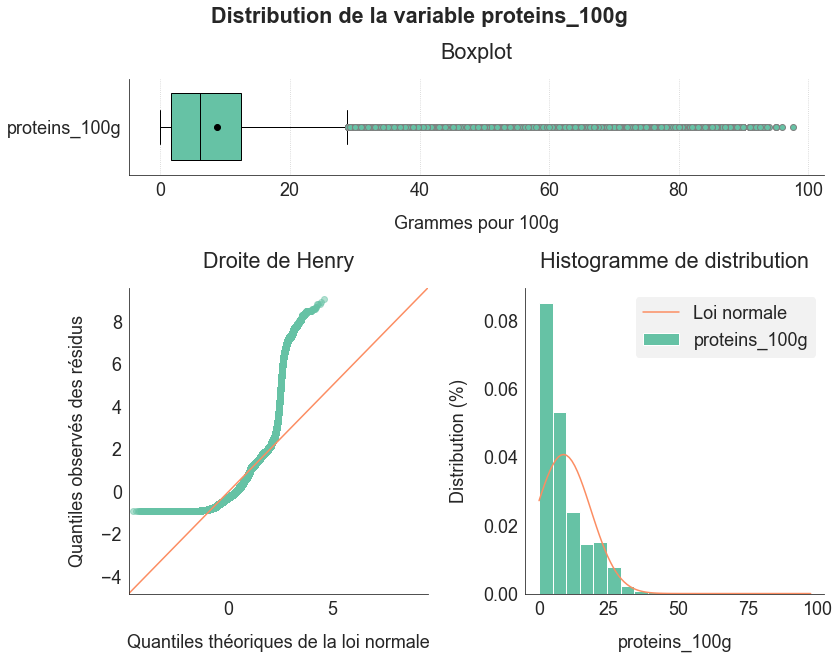

In [24]:
fig, ax = sfg.graph_analyse_variable_quant(data[col], nom_variable=col, \
                                          label_x_boxplot="Grammes pour 100g", figsize=(12,9))
save_fig("201_distribution_proteins")
plt.show()

#### 2.1.2. Variable fat_100g

In [25]:
idx_nutri = 1
col = col_nutri[idx_nutri]
col

'fat_100g'

In [26]:
sftd.test_normalite(data[col], title="Test de normalité pour la variable {}".format(col), return_print=True)

Test de normalité pour la variable fat_100g (niveau de risque = 5%)
   H0: La distribution suit une loi normale
   H1: La distribution ne suit pas une loi normale

           Kolmogorov-Smirnov   Jarque-Bera   Anderson-Darling 
p_value               0                 0               0      
Accept H0         False             False           False      



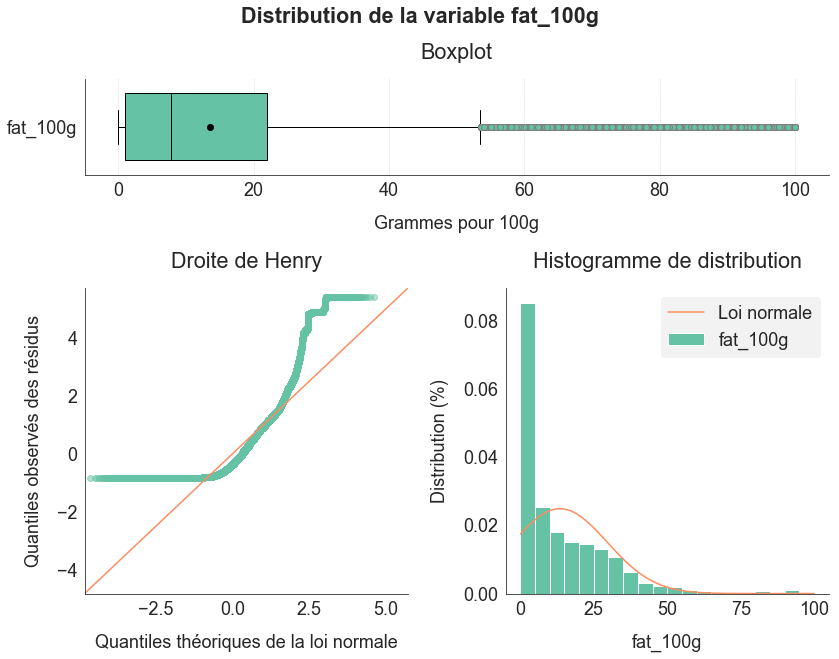

In [27]:
fig, ax = sfg.graph_analyse_variable_quant(data[col], nom_variable=col, \
                                          label_x_boxplot="Grammes pour 100g", figsize=(12,9))
save_fig("202_distribution_fat")
plt.show()

#### 2.1.3. Variable carbohydrates_100g

In [28]:
idx_nutri = 2
col = col_nutri[idx_nutri]
col

'carbohydrates_100g'

In [29]:
sftd.test_normalite(data[col], title="Test de normalité pour la variable {}".format(col), return_print=True)

Test de normalité pour la variable carbohydrates_100g (niveau de risque = 5%)
   H0: La distribution suit une loi normale
   H1: La distribution ne suit pas une loi normale

           Kolmogorov-Smirnov   Jarque-Bera   Anderson-Darling 
p_value               0                 0               0      
Accept H0         False             False           False      



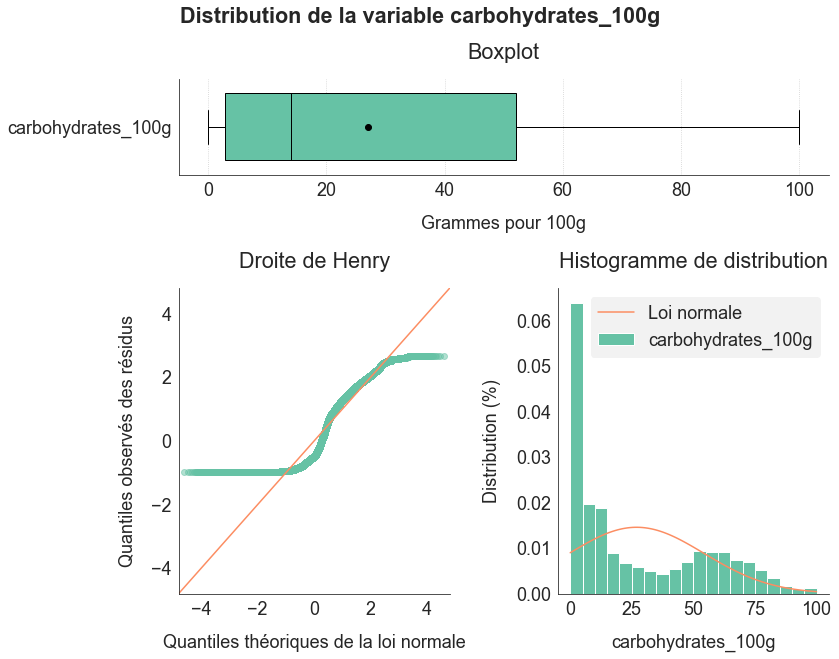

In [30]:
fig, ax = sfg.graph_analyse_variable_quant(data[col], nom_variable=col, \
                                          label_x_boxplot="Grammes pour 100g", figsize=(12,9))
save_fig("203_distribution_carbohydrates")
plt.show()

#### 2.1.4. Variable salt_100g

In [31]:
idx_nutri = 3
col = col_nutri[idx_nutri]
col

'salt_100g'

In [32]:
sftd.test_normalite(data[col], title="Test de normalité pour la variable {}".format(col), return_print=True)

Test de normalité pour la variable salt_100g (niveau de risque = 5%)
   H0: La distribution suit une loi normale
   H1: La distribution ne suit pas une loi normale

           Kolmogorov-Smirnov   Jarque-Bera   Anderson-Darling 
p_value               0                 0               0      
Accept H0         False             False           False      



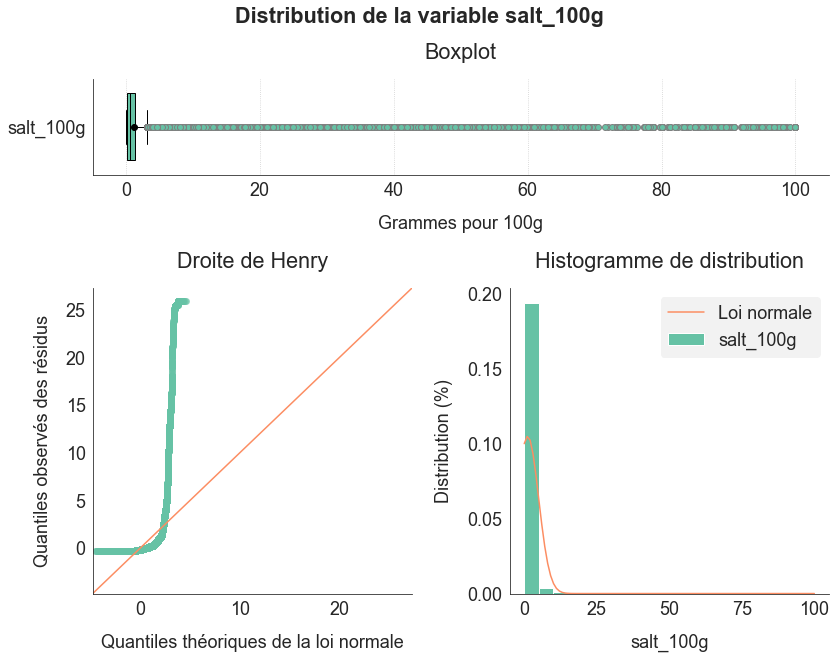

In [33]:
fig, ax = sfg.graph_analyse_variable_quant(data[col], nom_variable=col, \
                                          label_x_boxplot="Grammes pour 100g", figsize=(12,9))
save_fig("204_distribution_salt")
plt.show()

#### 2.1.5. Variable fiber_100g

In [34]:
idx_nutri = 4
col = col_nutri[idx_nutri]
col

'fiber_100g'

In [35]:
sftd.test_normalite(data[col], title="Test de normalité pour la variable {}".format(col), return_print=True)

Test de normalité pour la variable fiber_100g (niveau de risque = 5%)
   H0: La distribution suit une loi normale
   H1: La distribution ne suit pas une loi normale

           Kolmogorov-Smirnov   Jarque-Bera   Anderson-Darling 
p_value               0                 0               0      
Accept H0         False             False           False      



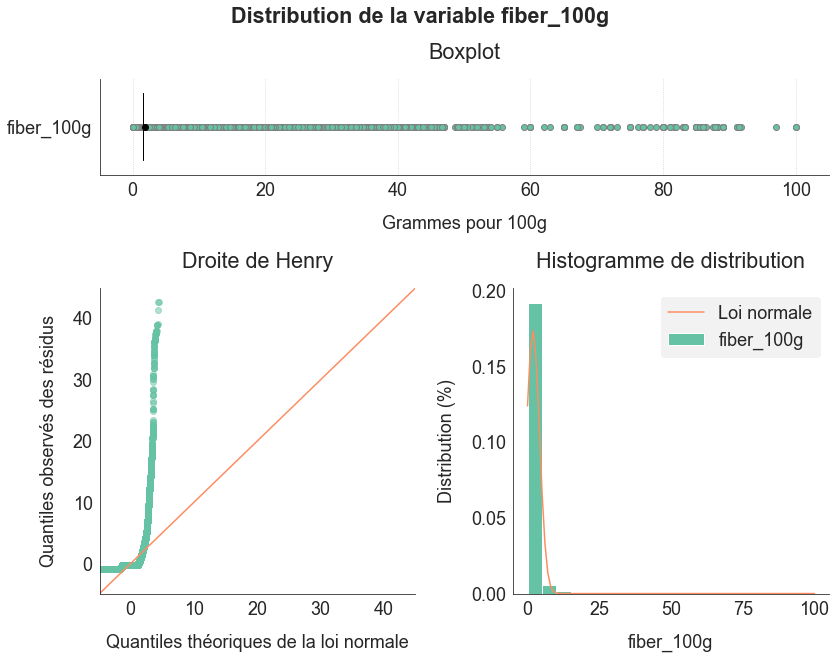

In [36]:
fig, ax = sfg.graph_analyse_variable_quant(data[col], nom_variable=col, \
                                          label_x_boxplot="Grammes pour 100g", figsize=(12,9))
save_fig("205_distribution_fiber")
plt.show()

#### 2.1.6. Variable saturated-fat_100g

In [37]:
idx_nutri = 5
col = col_nutri[idx_nutri]
col

'saturated-fat_100g'

In [38]:
sftd.test_normalite(data[col], title="Test de normalité pour la variable {}".format(col), return_print=True)

Test de normalité pour la variable saturated-fat_100g (niveau de risque = 5%)
   H0: La distribution suit une loi normale
   H1: La distribution ne suit pas une loi normale

           Kolmogorov-Smirnov   Jarque-Bera   Anderson-Darling 
p_value               0                 0               0      
Accept H0         False             False           False      



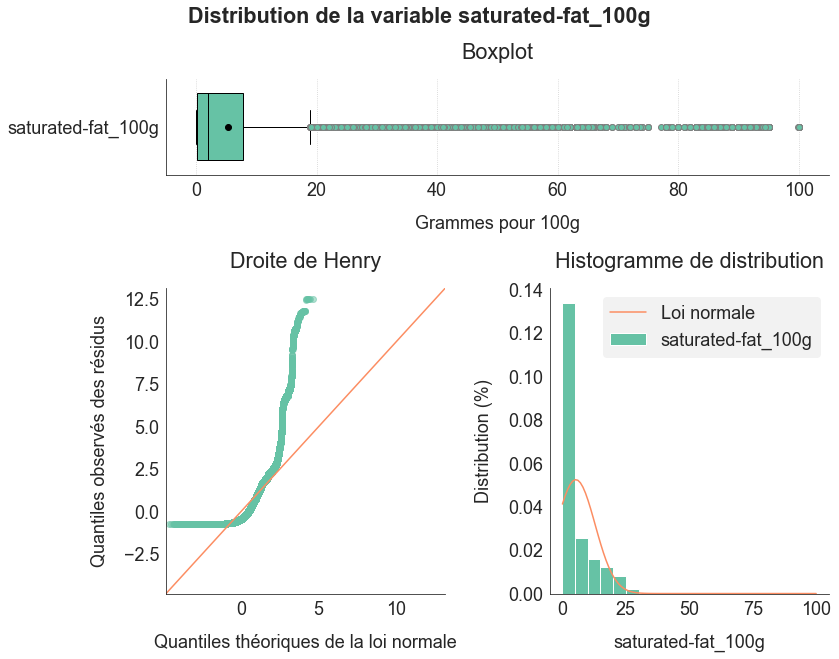

In [39]:
fig, ax = sfg.graph_analyse_variable_quant(data[col], nom_variable=col, \
                                          label_x_boxplot="Grammes pour 100g", figsize=(12,9))
save_fig("206_distribution_saturated_fat")
plt.show()

#### 2.1.7. Variable sugars_100g

In [40]:
idx_nutri = 6
col = col_nutri[idx_nutri]
col

'sugars_100g'

In [41]:
sftd.test_normalite(data[col], title="Test de normalité pour la variable {}".format(col), return_print=True)

Test de normalité pour la variable sugars_100g (niveau de risque = 5%)
   H0: La distribution suit une loi normale
   H1: La distribution ne suit pas une loi normale

           Kolmogorov-Smirnov   Jarque-Bera   Anderson-Darling 
p_value               0                 0               0      
Accept H0         False             False           False      



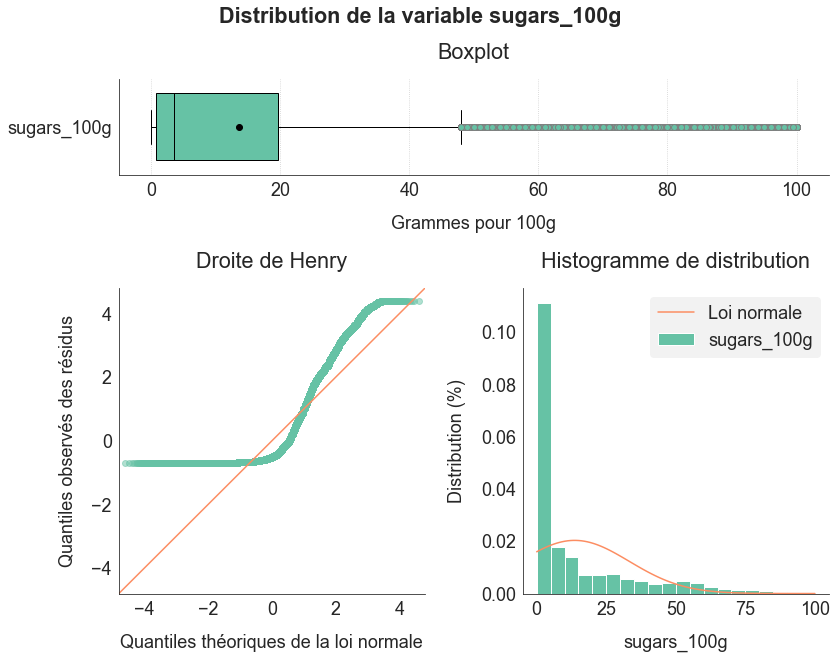

In [42]:
fig, ax = sfg.graph_analyse_variable_quant(data[col], nom_variable=col, \
                                          label_x_boxplot="Grammes pour 100g", figsize=(12,9))
save_fig("207_distribution_sugars")
plt.show()

#### 2.1.8. Variable energy_100g

In [43]:
idx_nutri = 7
col = col_nutri[idx_nutri]
col

'energy_100g'

In [44]:
sftd.test_normalite(data[col], title="Test de normalité pour la variable {}".format(col), return_print=True)

Test de normalité pour la variable energy_100g (niveau de risque = 5%)
   H0: La distribution suit une loi normale
   H1: La distribution ne suit pas une loi normale

           Kolmogorov-Smirnov   Jarque-Bera   Anderson-Darling 
p_value               0                 0               0      
Accept H0         False             False           False      



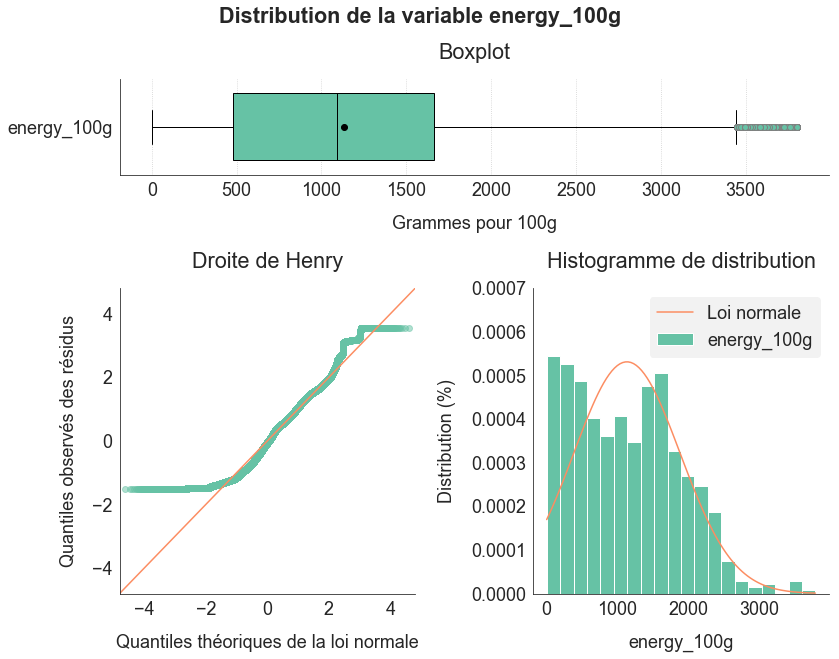

In [45]:
fig, ax = sfg.graph_analyse_variable_quant(data[col], nom_variable=col, \
                                          label_x_boxplot="Grammes pour 100g", figsize=(12,9))
ax[2].set_ylim([0,0.0007])
save_fig("208_distribution_energy")
plt.show()

#### 2.1.9. Observations sur les variables nutritionnelles

Aucune variable nutritionnelle ne suit une loi normale sans feature engineering.  
La conjonction d'un grand nombre de données aux valeurs peu élevées, notamment autour du seuil minimal de 0, et de la présence d'outliers aux valeurs relatives élevées fait que les distributions de ces variables sont asymétriques avec un fort skewness positif.

La variable energy_100g est la variable dont la distribution est la plus équilibrée. Toutefois, du fait du grand nombre de données aux valeurs peu élevées, elle présente un caractère multi-modal incompatible avec une distribution normale.

<a id='2_2'></a>

### 2.2. Variables de comptage

Pour les variables de comptage, des diagrammes circulaires ou des graphiques en barre seront plus adaptés pour comprendre la distribution des valeurs.

In [46]:
len(col_nb)

3

#### 2.2.1. Variable ingredients_from_palm_oil_n

In [47]:
idx_nb = 0
col = col_nb[idx_nb]
col

'ingredients_from_palm_oil_n'

In [48]:
distrib_values = data[col].value_counts()
labels = distrib_values.index.values.astype(int)
len(distrib_values)

4

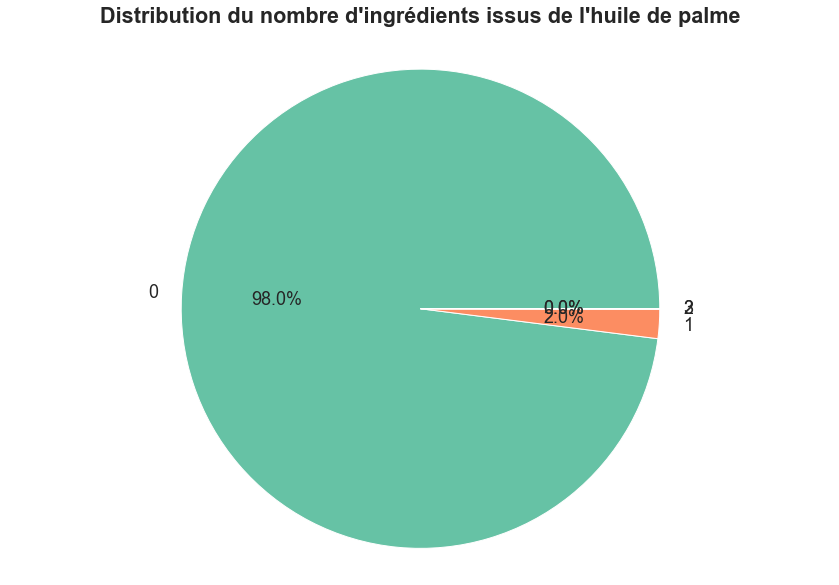

In [49]:
graph = sfg.MyGraph("Distribution du nombre d'ingrédients issus de l'huile de palme")
graph.add_pie(distrib_values.values, labels, startangle=0)
fig, ax = graph.fig, graph.ax
plt.show()

In [50]:
nb_regroupement = 1
regroupement = distrib_values[nb_regroupement:].copy()
regroupement_nom = "{} et plus".format(nb_regroupement)
distrib_values.drop(regroupement.index, inplace=True)
distrib_values[regroupement_nom] = regroupement.values.sum()
labels = labels[:nb_regroupement]
labels = np.append(labels, regroupement_nom)

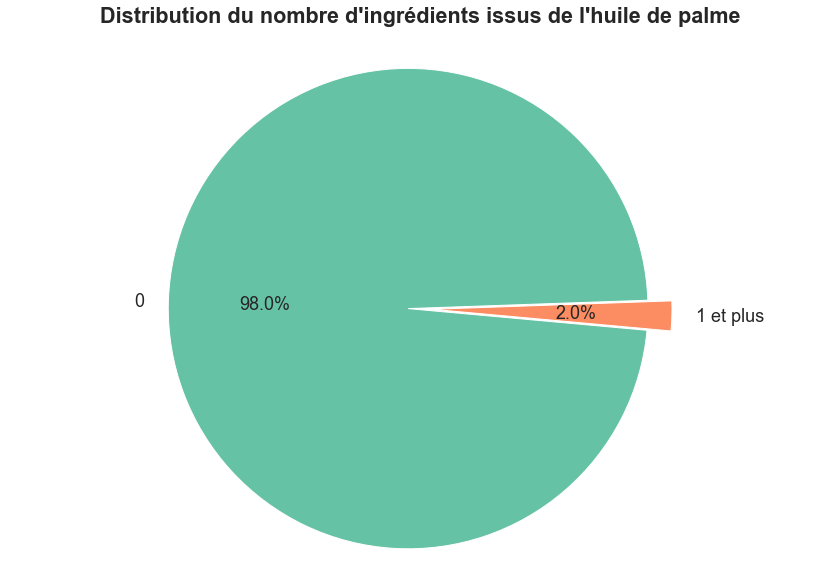

In [51]:
graph = sfg.MyGraph("Distribution du nombre d'ingrédients issus de l'huile de palme")
graph.add_pie(distrib_values.values, labels, explodes=[0,0.1], startangle=2)
fig, ax = graph.fig, graph.ax
save_fig("209_distribution_oilpalm")
plt.show()

Environ 35% de l'huile produite dans le monde est de l'huile de palme. On en trouve souvent dans les aliments transformés. Donc n'avoir que 2% de produits contenant des ingrédients issus de l'huile de palme ne paraît pas pertinent.

**<font color=red>Je renonce à utiliser la variable ingredients_from_palm_oil_n, dont le remplissage ne semble pas fiable.</font>** A faire confirmer par un expert métier.

#### 2.2.2. Variable additives_n

In [52]:
idx_nb = 1
col = col_nb[idx_nb]
col

'additives_n'

In [53]:
distrib_values = data[col].value_counts()
labels = distrib_values.index.values.astype(int)
len(distrib_values)

29

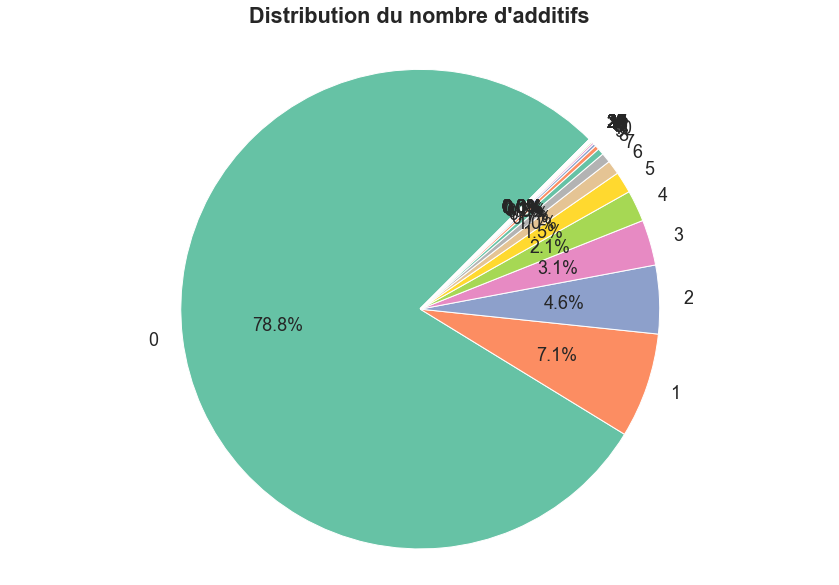

In [54]:
graph = sfg.MyGraph("Distribution du nombre d'additifs")
graph.add_pie(distrib_values.values, labels, startangle=45)
fig, ax = graph.fig, graph.ax
plt.show()

In [55]:
nb_regroupement = 5
regroupement = distrib_values[nb_regroupement:].copy()
regroupement_nom = "{} et plus".format(nb_regroupement)
distrib_values.drop(regroupement.index, inplace=True)
distrib_values[regroupement_nom] = regroupement.values.sum()
labels = labels[:nb_regroupement]
labels = np.append(labels, regroupement_nom)

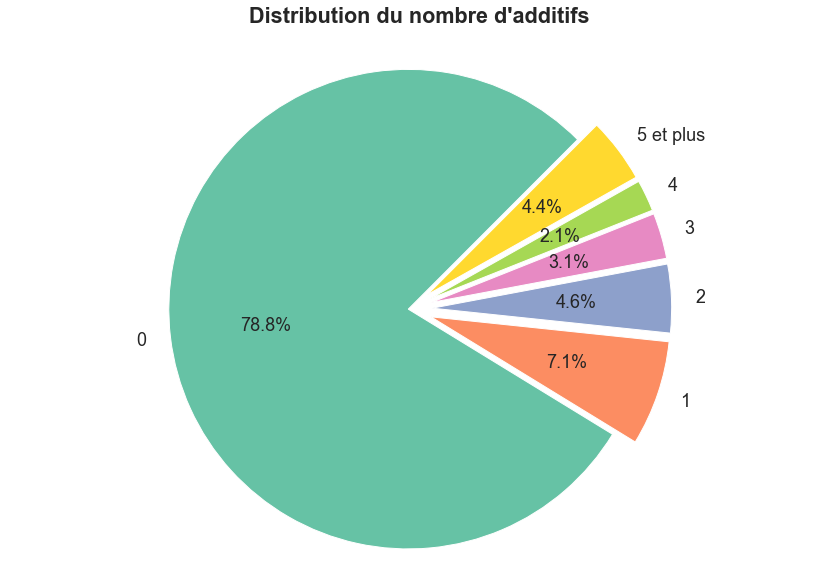

In [56]:
graph = sfg.MyGraph("Distribution du nombre d'additifs")
graph.add_pie(distrib_values.values, labels, explodes=[0,0.1,0.1,0.1,0.1,0.1], startangle=45)
fig, ax = graph.fig, graph.ax
save_fig("210_distribution_additives")
plt.show()

Moins d'un quart des aliments présents dans la base est enregistré comme contenant des additifs. Cela semble peu par rapport à l'usage très répandu des additifs, notamment pour (source : https://www.anses.fr/fr/content/le-point-sur-les-additifs-alimentaires) :
- garantir la qualité sanitaire des aliments (conservateurs, antioxydants) ;
- améliorer l'aspect et le goût d'une denrée (colorants, édulcorants, exhausteurs de goût) ;
- conférer une texture particulière (épaississants, gélifiants) ;
- garantir la stabilité du produit (émulsifiants, antiagglomérants, stabilisants).
  
A faire confirmer par un expert métier, qui peut aussi mener une analyse des additifs enregistrés pour vérifier si seuls les additifs dangereux pour la santé sont enregistrés.

**<font color=red>Je renonce à utiliser la variable additives_n, dont le remplissage ne semble pas fiable.</font>** A faire confirmer par un expert métier.

#### 2.2.3. Variable is_bio

In [57]:
idx_nb = 2
col = col_nb[idx_nb]
col

'is_bio'

In [58]:
distrib_values = data[col].value_counts()
labels = ["Aucun label bio","Au moins un label bio"]
len(distrib_values)

2

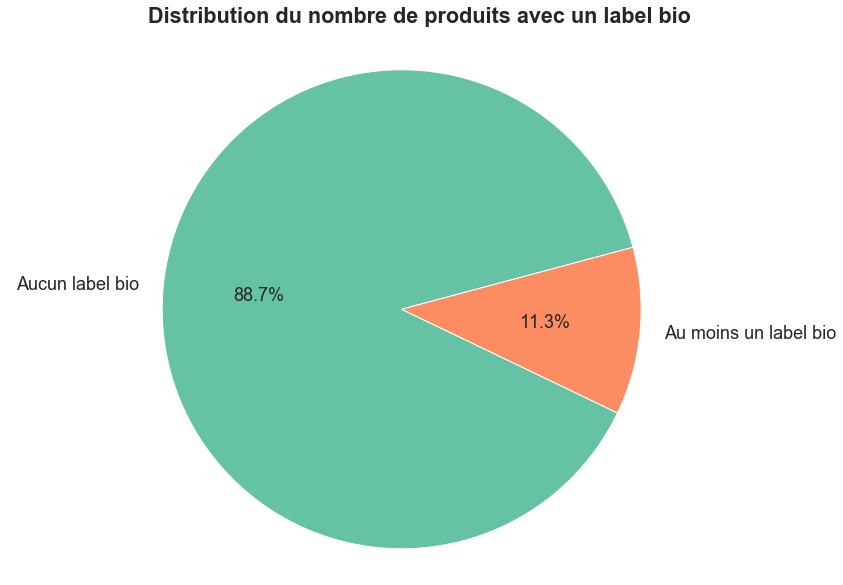

In [59]:
graph = sfg.MyGraph("Distribution du nombre de produits avec un label bio")
graph.add_pie(distrib_values.values, labels, startangle=15)
fig, ax = graph.fig, graph.ax
save_fig("211_distribution_isbio")
plt.show()

Un peu plus de 11% des produits de la base sont enregistrés comme ayant un label bio. Cela paraît cohérent avec ce que l'on peut voir dans les rayons des supermarchés.

Cette variable semble fiable.  
Encore une fois, à faire vérifier par un expert métier.

<a id='2_3'></a>

### 2.3. Variables liées au nutriscore

Pour les variables liées au nutriscore, l'approche est différente pour le score qui est une valeur numérique entière qui peut-être considérée comme continue entre -15 et +40 et le grade qui est une valeur catégorielle.

In [60]:
len(col_score)

2

#### 2.3.1. Variable nutriscore_score

In [61]:
idx_score = 0
col = col_score[idx_score]
col

'nutriscore_score'

In [62]:
sftd.test_normalite(data[col].dropna(), title="Test de normalité pour la variable {}".format(col), return_print=True)

Test de normalité pour la variable nutriscore_score (niveau de risque = 5%)
   H0: La distribution suit une loi normale
   H1: La distribution ne suit pas une loi normale

           Kolmogorov-Smirnov   Jarque-Bera   Anderson-Darling 
p_value               0                 0               0      
Accept H0         False             False           False      



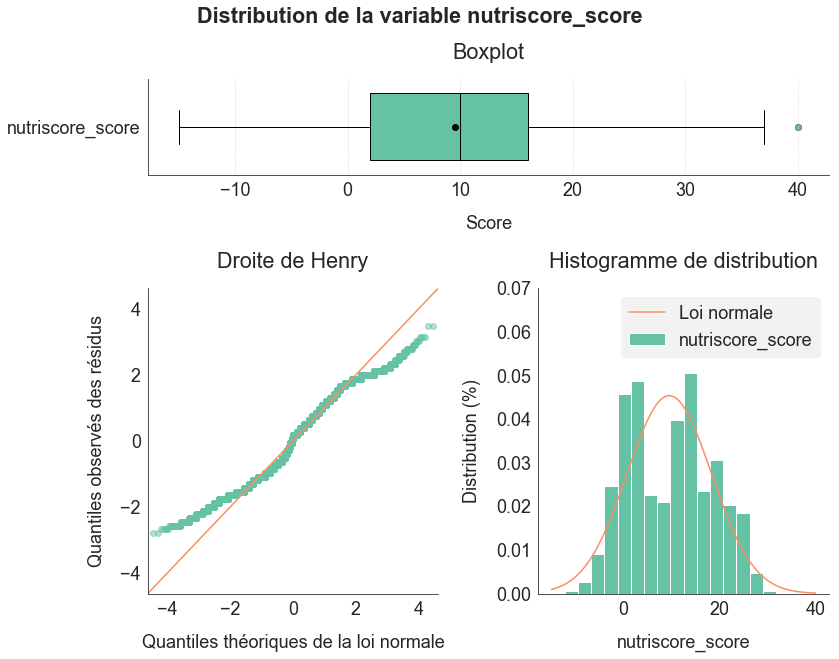

In [63]:
fig, ax = sfg.graph_analyse_variable_quant(data[col].dropna(), nom_variable=col, \
                                          label_x_boxplot="Score", figsize=(12,9))
ax[2].set_ylim([0,0.07])
save_fig("212_distribution_nutriscore_score")
plt.show()

Le nutriscore présente deux modes locaux : le premier correspond à un score de nutriscore légèrement supérieur à 0, le second à un score d'environ 15.

#### 2.3.2. Variable nutriscore_grade

In [64]:
idx_score = 1
col = col_score[idx_score]
col

'nutriscore_grade'

In [65]:
distrib_values = data[col].value_counts().sort_index()
labels = distrib_values.index.str.upper()
len(distrib_values)

5

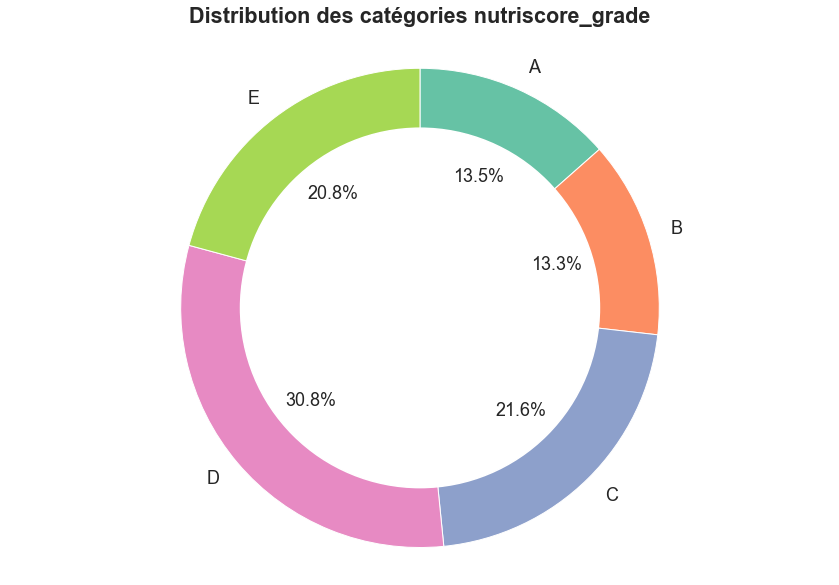

In [66]:
graph = sfg.MyGraph("Distribution des catégories nutriscore_grade")
graph.add_pie(distrib_values.values, labels, startangle=90, counterclock=False)
graph.add_cercle(0, 0, 0.75, facecolor='w')
fig, ax = graph.fig, graph.ax
save_fig("213_distribution_nutriscore_grade")
plt.show()

Environ un tiers des produits appartient à la catégorie D. Et plus de la moitié des produits appartiennent aux deux moins catégories : D et E.  
Les deux meilleurs catégories sont les moins bien représentées.

---
<a id='3_0'></a>

## <font color=blue>3. Analyses multivariées</font>

Je supprime les colonnes ingredients_from_palm_oil_n et additives_n qui ne sont pas fiables, et donc inutilisables dans mon application.

In [67]:
data.drop(columns=["ingredients_from_palm_oil_n","additives_n"], inplace=True)

### 3.1. Premier aperçu des relations entre les variables numériques

#### 3.1.1. Corrélations linéaires

In [68]:
valeurs = data.corr()
for lin in np.arange(0, valeurs.shape[0]):
    for col in np.arange(0, lin, 1):
        valeurs.iloc[lin, col] = np.nan
annotations = np.round(valeurs, 2)

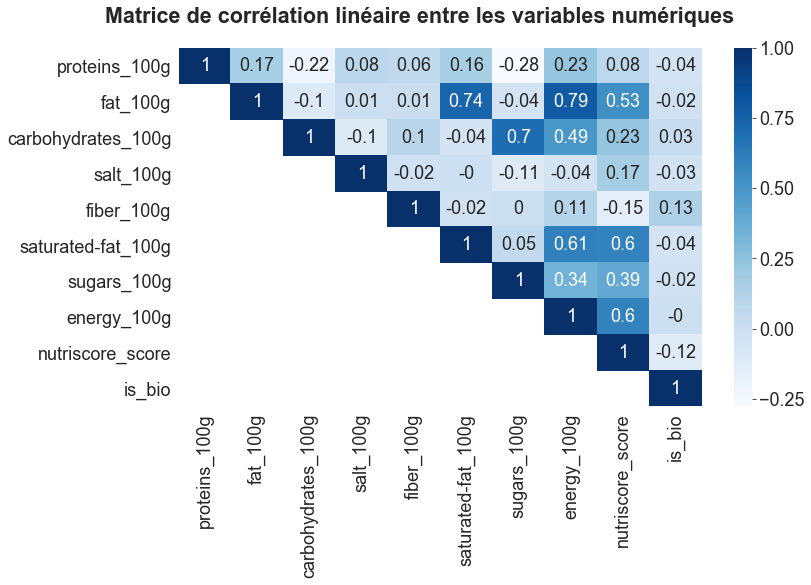

In [69]:
graph = sfg.MyGraph("Matrice de corrélation linéaire entre les variables numériques")
graph.add_sns_heatmap(valeurs, annotations=annotations)
fig, ax  = graph.fig, graph.ax
save_fig("214_matrice_correlation")
plt.show()

Les remarques suivantes sont basées sur des relations linéaires. Le calcul des coefficients de corrélation de Pearson repose sur l'hypothèse que les variables suivent une distribution normale. Comme ce n'est pas le cas de nos variables, ces coefficients sont à considérer avec précaution.

Je remarque une corrélation positive marquée entre les variables :
- fat_100g et saturated-fat_100g : logique car la seconde est une sous-catégorie de la première ;
- carbohydrates_100g et sugars_100g : logique car la seconde est une sous-catégorie de la première ;
- fat_100g et energy_100g : la valeur énergétique semble fortement influencée par les lipides qui apportent 38 kJ par gramme de graisse (alors que les glucides et les protéines apportent chacun 17 kJ par gramme, et les fibres 8kJ par gramme).

Les variables proteins_100g, salt_100g et fiber_100g semblent n'être liées à aucune autre variable.

La variable nutriscore pourrait bien être une combinaison linéaire de plusieurs des variables nutritionnelles.

Les variables de comptage des ingrédients issus de l'huile de palme, des additifs et du label bio semblent ne pas être corrélées aux autres variables.

#### 3.1.2. Diagrammes de dispersion

Je trace le pairplot des variables de mesure nutritionnelle et du nutriscore.  
Pour avoir moins de variables, et donc un pairplot plus lisible, je ne grade que les variables qui présentent des valeurs intéressantes dans la matrice de corrélation. Ainsi, je ne conserve pas proteins_100g, salt_100g et fiber_100g qui n'ont aucune corrélation en valeur absolue supérieure à 0,3.  
Je supprime les lignes où je n'ai pas de données pour le nutriscore.

In [70]:
pairplot_data = data[["fat_100g", "saturated-fat_100g", "carbohydrates_100g", "sugars_100g",
                     "energy_100g", "nutriscore_score"]].dropna()

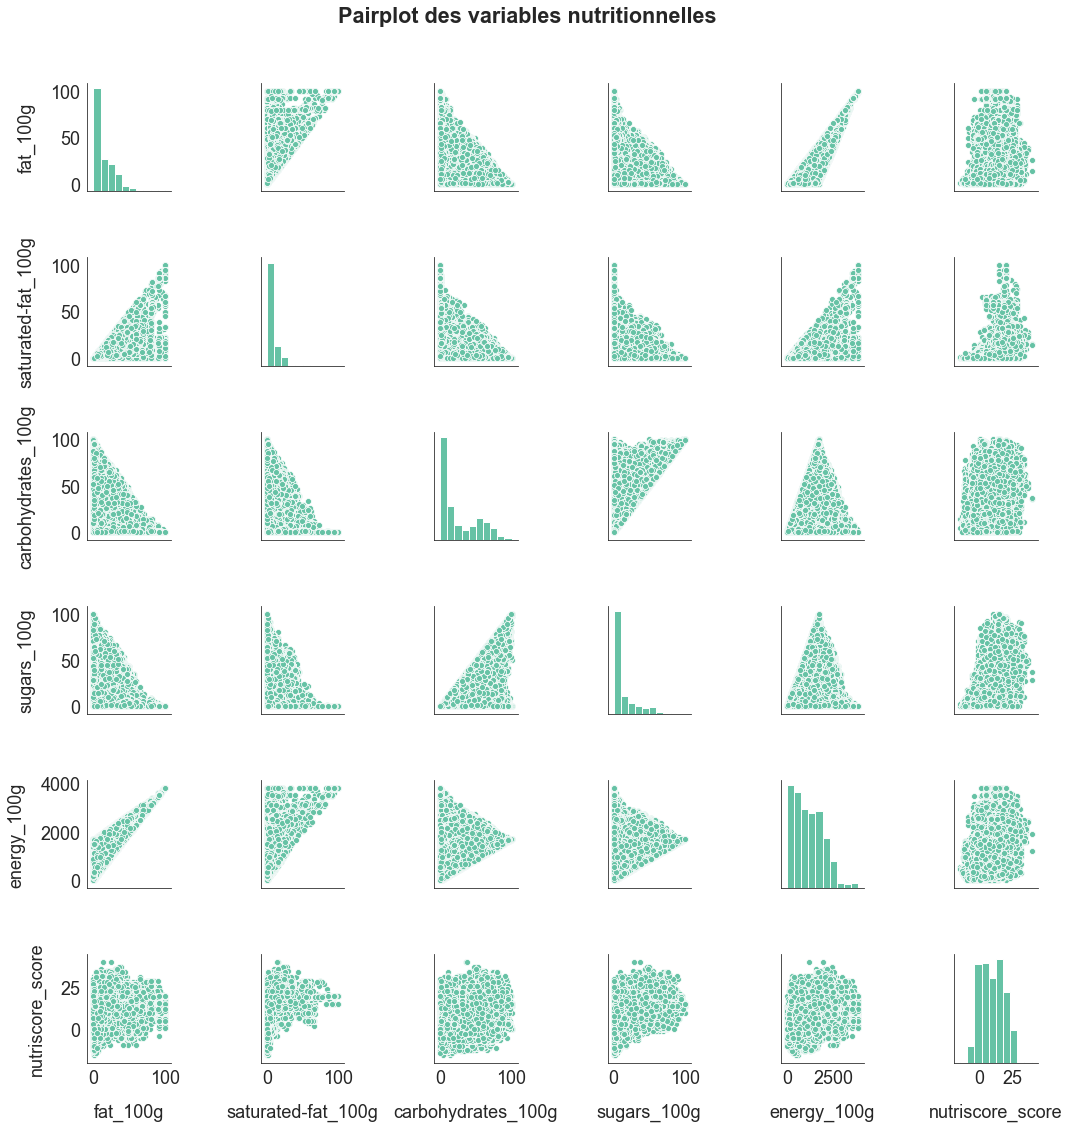

In [71]:
fig, ax = sfg.sns_pairplot(pairplot_data, title="Pairplot des variables nutritionnelles")
save_fig("215_pairplot")
plt.show()

Ce graphique confirme des **éléments logiques du point de vue nutritionnel** :
- La forme en triangle rectangle isocèle du graphique des graisses en fonction des graisses saturées vient du fait que la deuxième variable est une sous-catégorie de la première ;
- Idem pour les glucides et les sucres ;
- La forme proche d'un triangle rectangle isocèle du graphique des graisses en fonction des glucides s'explique par le fait que la somme des macro-nutriments pour 100g d'aliment ne peut excéder 100g. De ce fait, l'augmentation d'un facteur entraîne automatiquement la baisse d'un ou plusieurs autres facteurs nutritionnels.
  
Ce graphique met également en avant **certains éléments sur les valeurs énergétiques** :
- Les valeurs énergétiques sont fortement corrélées positivement aux graisses contenues dans l'aliment. C'est le seul graphique qui montre une relation linéaire forte et lisible ;
- La forme en fanion de l'énergie en fonction des glucides indique qu'il n'y a pas de relation linéaire entre ces deux variables. Par contre, la quantité de glucides borne la valeur énergétique d'un produit.  
  
Enfin, ce graphique donne **quelques enseignements sur le nutriscore** (pour rappel, plus la note du nutriscore est basse, meilleure elle est) :
- le nutriscore ne semble pas lié à une seule variable nutritionnelle prise isolément. Les points des graphiques sont dans l'ensemble très dispersés ne montrant aucune relation linéaire nette avec les variables nutritionnelles ;
- les aliments avec les meilleurs nutriscores ont peu de graisses, et en particulier peu de graisses saturées. Mais certains aliments avec peu de graisses ou de graisses saturées obtiennent aussi de mauvais nutriscores ;
- a contrario, les aliments avec le plus de graisses ou de graisses saturées ne sont pas ceux qui obtiennent les moins bonnes notations ;
- les aliments avec les meilleurs nutriscores ont peu de sucre mais peuvent contenir une grande quantité de glucides. Mais certains aliments avec peu de sucre obtiennent également de mauvais nutriscores.

<a id='3_2'></a>

### 3.2. Etude des corrélations entre les variables nutritionnelles

Pour les graphiques de cette partie, je n'affiche pas de couleurs différentes selon la catégorie de Nutriscore car beaucoup d'enregistrements n'ont pas l'information de cette catégorie.

#### 3.2.1. Corrélations de la variable proteins_100g

In [72]:
current_idx = 0
col_autres = col_nutri[current_idx+1:]

In [73]:
sftd.test_correlations_linear(data, col_nutri[current_idx], col_autres, return_print=True)

Test de corrélation linéaire (niveau de risque = 5%)
   H0: Le coefficient de corrélation linéaire de la variable proteins_100g avec les variables suivantes est nul (r=0)
   H1: Le coefficient de corrélation linéaire n'est pas nul (r!=0)

                   Pearson Correlation p_value  Accept H0         Conclusion       
fat_100g                  0.170977         0      False    Coefficient significatif
carbohydrates_100g       -0.217446         0      False    Coefficient significatif
salt_100g                0.0830603         0      False    Coefficient significatif
fiber_100g               0.0636037         0      False    Coefficient significatif
saturated-fat_100g         0.16055         0      False    Coefficient significatif
sugars_100g              -0.276911         0      False    Coefficient significatif
energy_100g               0.227034         0      False    Coefficient significatif



Les tests de corrélation linéaire indiquent que tous les coefficients sont significatifs. Les p-values obtenues sont à prendre avec précaution car les variables n'ont pas une distribution normale.  
Tous les coefficients de corrélation sont faibles. Il n'y a aucune relation intéressante.

#### 3.2.2. Corrélations de la variable fat_100g

In [74]:
current_idx = 1
col_autres = col_nutri[:current_idx]
col_autres.extend(col_nutri[current_idx+1:])

In [75]:
sftd.test_correlations_linear(data, col_nutri[current_idx], col_autres, return_print=True)

Test de corrélation linéaire (niveau de risque = 5%)
   H0: Le coefficient de corrélation linéaire de la variable fat_100g avec les variables suivantes est nul (r=0)
   H1: Le coefficient de corrélation linéaire n'est pas nul (r!=0)

                   Pearson Correlation    p_value     Accept H0         Conclusion       
proteins_100g             0.170977                 0    False    Coefficient significatif
carbohydrates_100g      -0.0980826                 0    False    Coefficient significatif
salt_100g               0.00620245       8.31658e-06    False    Coefficient significatif
fiber_100g               0.0132982       1.22406e-21    False    Coefficient significatif
saturated-fat_100g        0.737632                 0    False    Coefficient significatif
sugars_100g             -0.0399087      5.35728e-181    False    Coefficient significatif
energy_100g               0.789459                 0    False    Coefficient significatif



Tous les coefficients de corrélation sont significatifs. Deux coefficients élevés sont intéressants car ils montrent l'existence d'un lien linéaire :
- la relation entre fat_100g et saturated-fat_100g semble assez évidente car la deuxième est une sous-catégorie de la première ;
- la relation entre fat_100g et energy_100g provient du fait que les graisses sont le principal contributeur à l'énergie d'un aliment (38 kJ par gramme de lipide contre 17 kJ par gramme de glucide ou de protéine).

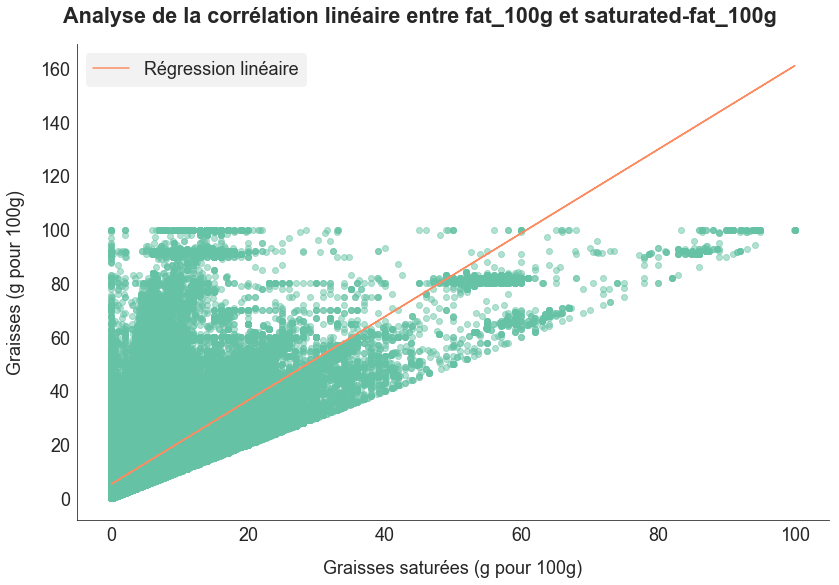

In [76]:
compare_to = 4
graph = sfg.MyGraph("Analyse de la corrélation linéaire entre {} et {}".format(col_nutri[current_idx], col_autres[compare_to]))
graph.graph_custom_regplot(data, col_autres[compare_to], col_nutri[current_idx])
graph.set_axe_x(label="Graisses saturées (g pour 100g)")
graph.set_axe_y(label="Graisses (g pour 100g)")
fig, ax  = graph.fig, graph.ax
save_fig("216_correlation_fat_satfat")
plt.show()

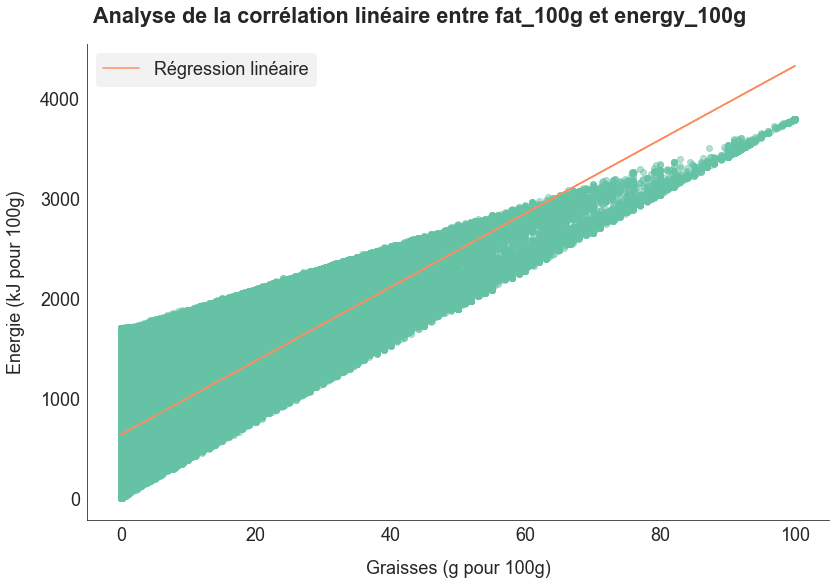

In [77]:
compare_to = 6
graph = sfg.MyGraph("Analyse de la corrélation linéaire entre {} et {}".format(col_nutri[current_idx], col_autres[compare_to]))
graph.graph_custom_regplot(data, col_nutri[current_idx], col_autres[compare_to])
graph.set_axe_x(label="Graisses (g pour 100g)")
graph.set_axe_y(label="Energie (kJ pour 100g)")
fig, ax  = graph.fig, graph.ax
save_fig("217_correlation_energy_fat")
plt.show()

In [78]:
sftd.test_correlations_rank(data, col_nutri[current_idx], col_autres, return_print=True)

Test de corrélation de rang (niveau de risque = 5%)
   H0: Le coefficient de corrélation de rang de la variable fat_100g avec les variables suivantes est nul (r=0)
   H1: Le coefficient de corrélation de rang n'est pas nul (r!=0)

                   Spearman Correlation    p_value     Accept H0         Conclusion       
proteins_100g             0.500587                  0    False    Coefficient significatif
carbohydrates_100g       -0.049695       1.31066e-279    False    Coefficient significatif
salt_100g                  0.36419                  0    False    Coefficient significatif
fiber_100g               0.0808244                  0    False    Coefficient significatif
saturated-fat_100g        0.907414                  0    False    Coefficient significatif
sugars_100g              -0.037027       4.52408e-156    False    Coefficient significatif
energy_100g               0.754067                  0    False    Coefficient significatif



Le coefficient de corrélation de Spearman confirme que nous avons une relation croissante entre saturated-fat et fat presque monotone.

#### 3.2.3. Corrélations de la variable carbohydrates_100g

In [79]:
current_idx = 2
col_autres = col_nutri[:current_idx]
col_autres.extend(col_nutri[current_idx+1:])

In [80]:
sftd.test_correlations_linear(data, col_nutri[current_idx], col_autres, return_print=True)

Test de corrélation linéaire (niveau de risque = 5%)
   H0: Le coefficient de corrélation linéaire de la variable carbohydrates_100g avec les variables suivantes est nul (r=0)
   H1: Le coefficient de corrélation linéaire n'est pas nul (r!=0)

                   Pearson Correlation    p_value     Accept H0         Conclusion       
proteins_100g            -0.217446                 0    False    Coefficient significatif
fat_100g                -0.0980826                 0    False    Coefficient significatif
salt_100g                -0.103264                 0    False    Coefficient significatif
fiber_100g               0.0975623                 0    False    Coefficient significatif
saturated-fat_100g      -0.0423971      5.02282e-204    False    Coefficient significatif
sugars_100g               0.700622                 0    False    Coefficient significatif
energy_100g               0.494013                 0    False    Coefficient significatif



Tous les coefficients de corrélation sont significatifs.  
Le coefficient de corrélation linéaire entre carbohydrates_100g et sugars_100g est élevé et confirme une relation évidente entre ces deux variables étant donné que la deuxième est une sous-catégorie de la première.  
L'énergie pour 100g semble avoir un lien modéré avec la quantité de glucides.

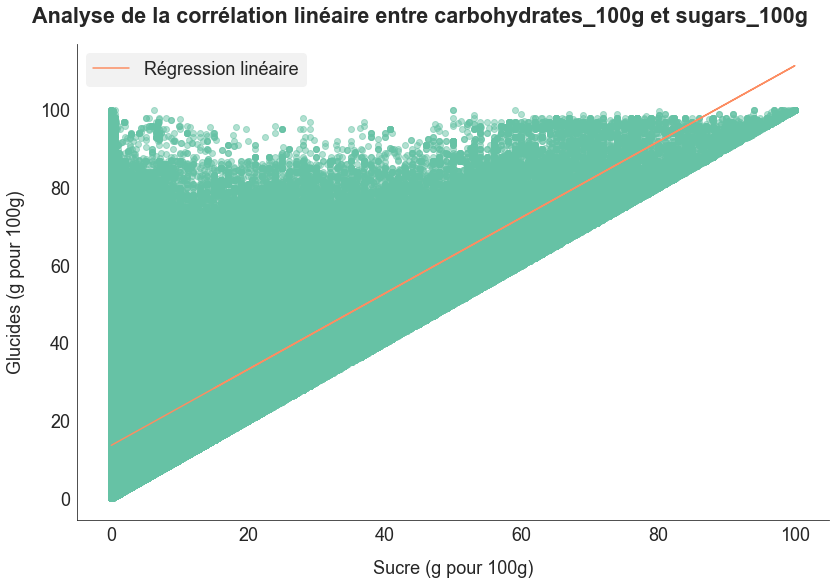

In [81]:
compare_to = 5
graph = sfg.MyGraph("Analyse de la corrélation linéaire entre {} et {}".format(col_nutri[current_idx], col_autres[compare_to]))
graph.graph_custom_regplot(data, col_autres[compare_to], col_nutri[current_idx])
graph.set_axe_x(label="Sucre (g pour 100g)")
graph.set_axe_y(label="Glucides (g pour 100g)")
fig, ax  = graph.fig, graph.ax
save_fig("218_correlation_carbohydrates_sugars")
plt.show()

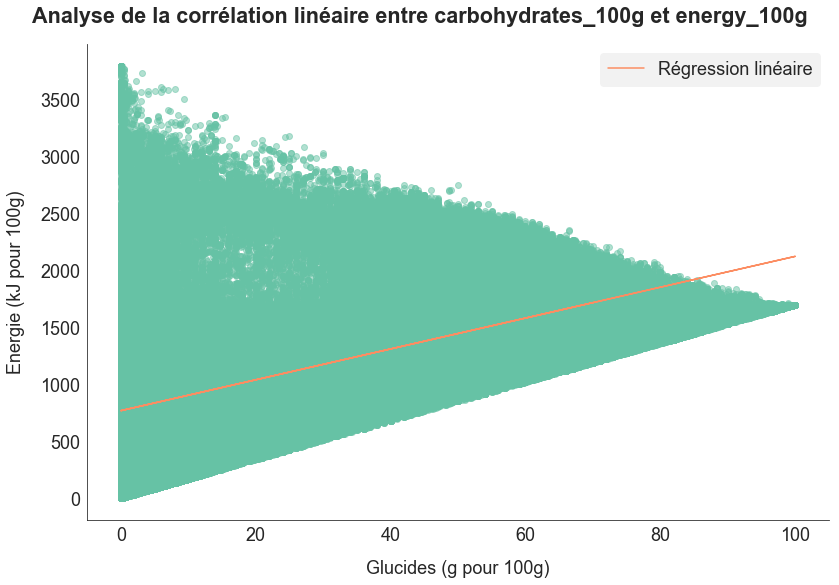

In [82]:
compare_to = 6
graph = sfg.MyGraph("Analyse de la corrélation linéaire entre {} et {}".format(col_nutri[current_idx], col_autres[compare_to]))
graph.graph_custom_regplot(data, col_nutri[current_idx], col_autres[compare_to])
graph.set_axe_x(label="Glucides (g pour 100g)")
graph.set_axe_y(label="Energie (kJ pour 100g)")
fig, ax  = graph.fig, graph.ax
save_fig("219_correlation_energy_carbohydrates")
plt.show()

In [83]:
sftd.test_correlations_rank(data, col_nutri[current_idx], col_autres, return_print=True)

Test de corrélation de rang (niveau de risque = 5%)
   H0: Le coefficient de corrélation de rang de la variable carbohydrates_100g avec les variables suivantes est nul (r=0)
   H1: Le coefficient de corrélation de rang n'est pas nul (r!=0)

                   Spearman Correlation    p_value     Accept H0         Conclusion       
proteins_100g            -0.156332                  0    False    Coefficient significatif
fat_100g                 -0.049695       1.31066e-279    False    Coefficient significatif
salt_100g                -0.264316                  0    False    Coefficient significatif
fiber_100g                0.187645                  0    False    Coefficient significatif
saturated-fat_100g      -0.0456848       1.36902e-236    False    Coefficient significatif
sugars_100g               0.738062                  0    False    Coefficient significatif
energy_100g               0.481128                  0    False    Coefficient significatif



Les coefficients de Spearman montrent que ces deux relations ne sont pas purement monotones (surtout la relation entre l'énergie et les glucides).

#### 3.2.4. Corrélations de la variable salt_100g

In [84]:
current_idx = 3
col_autres = col_nutri[:current_idx]
col_autres.extend(col_nutri[current_idx+1:])

In [85]:
sftd.test_correlations_linear(data, col_nutri[current_idx], col_autres, return_print=True)

Test de corrélation linéaire (niveau de risque = 5%)
   H0: Le coefficient de corrélation linéaire de la variable salt_100g avec les variables suivantes est nul (r=0)
   H1: Le coefficient de corrélation linéaire n'est pas nul (r!=0)

                   Pearson Correlation    p_value     Accept H0         Conclusion       
proteins_100g            0.0830603                 0    False    Coefficient significatif
fat_100g                0.00620245       8.31658e-06    False    Coefficient significatif
carbohydrates_100g       -0.103264                 0    False    Coefficient significatif
fiber_100g              -0.0167233       2.87377e-33    False    Coefficient significatif
saturated-fat_100g     -0.00447063        0.00131618    False    Coefficient significatif
sugars_100g              -0.114457                 0    False    Coefficient significatif
energy_100g             -0.0409514      1.77614e-190    False    Coefficient significatif



Tous les coefficients de corrélation sont significatifs.  
Aucun coefficient n'a une valeur suffisamment élevée pour pousser plus loin l'exploration.

#### 3.2.5. Corrélations de la variable fiber_100g

In [86]:
current_idx = 4
col_autres = col_nutri[:current_idx]
col_autres.extend(col_nutri[current_idx+1:])

In [87]:
sftd.test_correlations_linear(data, col_nutri[current_idx], col_autres, return_print=True)

Test de corrélation linéaire (niveau de risque = 5%)
   H0: Le coefficient de corrélation linéaire de la variable fiber_100g avec les variables suivantes est nul (r=0)
   H1: Le coefficient de corrélation linéaire n'est pas nul (r!=0)

                   Pearson Correlation   p_value     Accept H0         Conclusion       
proteins_100g            0.0636037                0    False    Coefficient significatif
fat_100g                 0.0132982      1.22406e-21    False    Coefficient significatif
carbohydrates_100g       0.0975623                0    False    Coefficient significatif
salt_100g               -0.0167233      2.87377e-33    False    Coefficient significatif
saturated-fat_100g      -0.0189692       2.5929e-42    False    Coefficient significatif
sugars_100g             0.00294658        0.0342349    False    Coefficient significatif
energy_100g               0.109775                0    False    Coefficient significatif



Tous les coefficients de corrélation sont significatifs.  
Aucun coefficient n'a une valeur suffisamment élevée pour pousser plus loin l'exploration.

#### 3.2.6. Corrélations de la variable saturated-fat_100g

In [88]:
current_idx = 5
col_autres = col_nutri[:current_idx]
col_autres.extend(col_nutri[current_idx+1:])

In [89]:
sftd.test_correlations_linear(data, col_nutri[current_idx], col_autres, return_print=True)

Test de corrélation linéaire (niveau de risque = 5%)
   H0: Le coefficient de corrélation linéaire de la variable saturated-fat_100g avec les variables suivantes est nul (r=0)
   H1: Le coefficient de corrélation linéaire n'est pas nul (r!=0)

                   Pearson Correlation    p_value     Accept H0         Conclusion       
proteins_100g              0.16055                 0    False    Coefficient significatif
fat_100g                  0.737632                 0    False    Coefficient significatif
carbohydrates_100g      -0.0423971      5.02282e-204    False    Coefficient significatif
salt_100g              -0.00447063        0.00131618    False    Coefficient significatif
fiber_100g              -0.0189692        2.5929e-42    False    Coefficient significatif
sugars_100g              0.0549503                 0    False    Coefficient significatif
energy_100g               0.607799                 0    False    Coefficient significatif



Tous les coefficients de corrélation sont significatifs.  
Nous avons déjà étudié la relation entre fat_100g et saturated-fat_100g.  
Etudions celle entre l'énergie pour 100g et les graisses saturées, même si le coefficient de corrélation n'est pas très élevé.

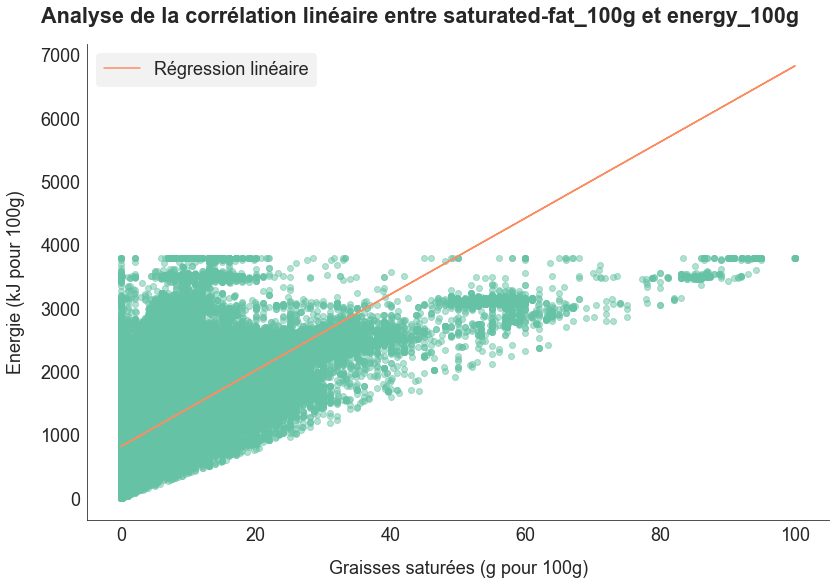

In [90]:
compare_to = 6
graph = sfg.MyGraph("Analyse de la corrélation linéaire entre {} et {}".format(col_nutri[current_idx], col_autres[compare_to]))
graph.graph_custom_regplot(data, col_nutri[current_idx], col_autres[compare_to])
graph.set_axe_x(label="Graisses saturées (g pour 100g)")
graph.set_axe_y(label="Energie (kJ pour 100g)")
fig, ax  = graph.fig, graph.ax
save_fig("220_correlation_energy_satfat")
plt.show()

In [91]:
sftd.test_correlations_rank(data, col_nutri[current_idx], col_autres, return_print=True)

Test de corrélation de rang (niveau de risque = 5%)
   H0: Le coefficient de corrélation de rang de la variable saturated-fat_100g avec les variables suivantes est nul (r=0)
   H1: Le coefficient de corrélation de rang n'est pas nul (r!=0)

                   Spearman Correlation    p_value     Accept H0         Conclusion       
proteins_100g             0.482687                  0    False    Coefficient significatif
fat_100g                  0.907414                  0    False    Coefficient significatif
carbohydrates_100g      -0.0456848       1.36902e-236    False    Coefficient significatif
salt_100g                 0.338821                  0    False    Coefficient significatif
fiber_100g               0.0407263       2.07253e-188    False    Coefficient significatif
sugars_100g              0.0102655        1.62386e-13    False    Coefficient significatif
energy_100g               0.667461                  0    False    Coefficient significatif



Energy_100g a une relation linéaire moins forte et moins monotone avec saturated-fat_100g qu'avec fat_100g.

#### 3.2.7. Corrélations de la variable sugars_100g

In [92]:
current_idx = 6
col_autres = col_nutri[:current_idx]
col_autres.extend(col_nutri[current_idx+1:])

In [93]:
sftd.test_correlations_linear(data, col_nutri[current_idx], col_autres, return_print=True)

Test de corrélation linéaire (niveau de risque = 5%)
   H0: Le coefficient de corrélation linéaire de la variable sugars_100g avec les variables suivantes est nul (r=0)
   H1: Le coefficient de corrélation linéaire n'est pas nul (r!=0)

                   Pearson Correlation    p_value     Accept H0         Conclusion       
proteins_100g            -0.276911                 0    False    Coefficient significatif
fat_100g                -0.0399087      5.35728e-181    False    Coefficient significatif
carbohydrates_100g        0.700622                 0    False    Coefficient significatif
salt_100g                -0.114457                 0    False    Coefficient significatif
fiber_100g              0.00294658         0.0342349    False    Coefficient significatif
saturated-fat_100g       0.0549503                 0    False    Coefficient significatif
energy_100g               0.340343                 0    False    Coefficient significatif



Tous les coefficients de corrélation sont significatifs.  
Nous avons déjà étudié la seule relation qui semble intéressante, entre carbohydrates_100g et sugars_100g.

#### 3.2.8. Corrélations de la variable energy_100g

In [94]:
current_idx = 7
col_autres = col_nutri[:current_idx]

In [95]:
sftd.test_correlations_linear(data, col_nutri[current_idx], col_autres, return_print=True)

Test de corrélation linéaire (niveau de risque = 5%)
   H0: Le coefficient de corrélation linéaire de la variable energy_100g avec les variables suivantes est nul (r=0)
   H1: Le coefficient de corrélation linéaire n'est pas nul (r!=0)

                   Pearson Correlation    p_value     Accept H0         Conclusion       
proteins_100g             0.227034                 0    False    Coefficient significatif
fat_100g                  0.789459                 0    False    Coefficient significatif
carbohydrates_100g        0.494013                 0    False    Coefficient significatif
salt_100g               -0.0409514      1.77614e-190    False    Coefficient significatif
fiber_100g                0.109775                 0    False    Coefficient significatif
saturated-fat_100g        0.607799                 0    False    Coefficient significatif
sugars_100g               0.340343                 0    False    Coefficient significatif



Ces paires ont déjà été analysées auparavant.  
L'énergie est principalement liée linéairement aux graisses, moyennement aux glucides et peu aux protéines.

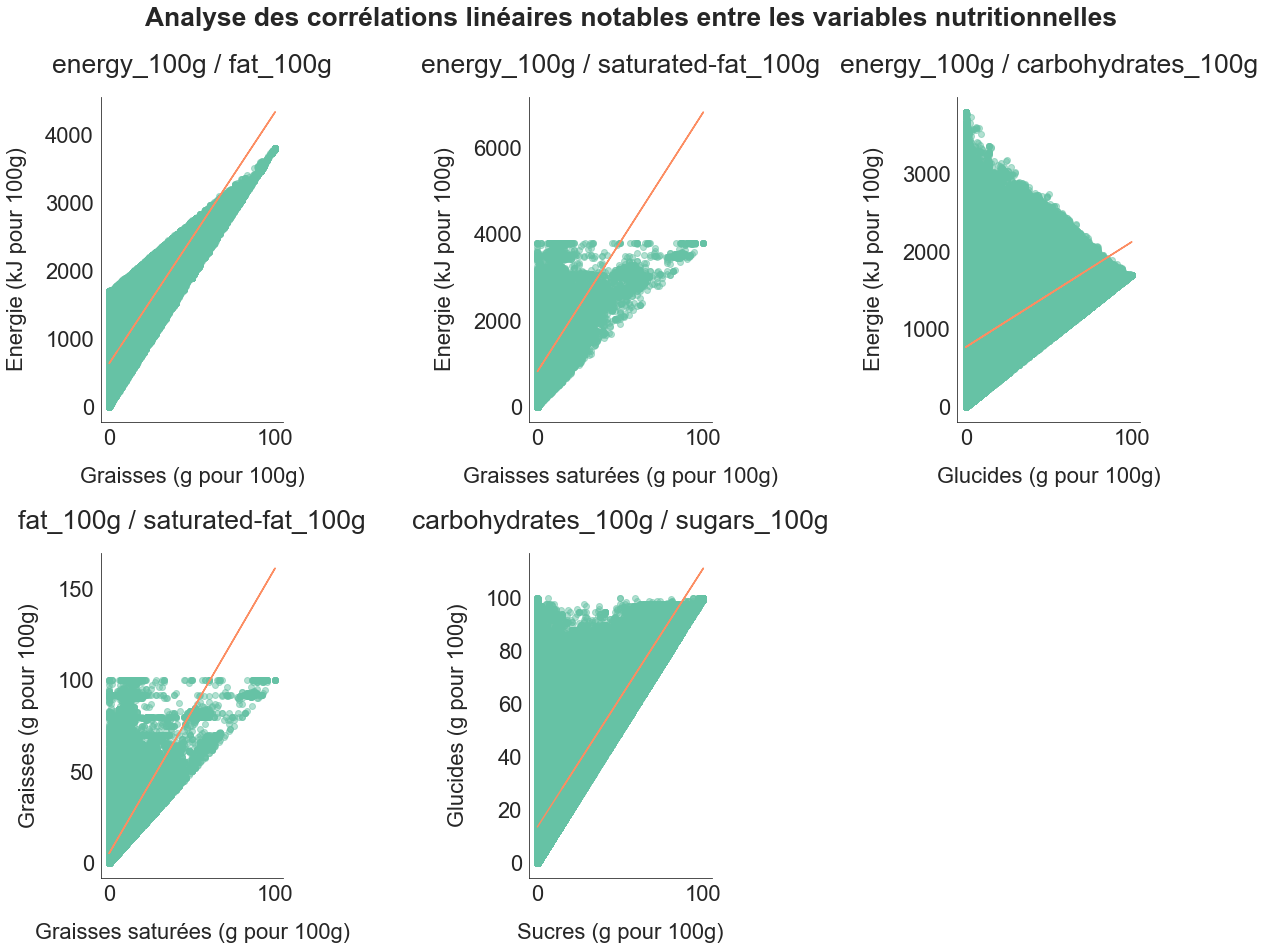

In [189]:
# graphique pour la présentation
analysis_pairs = [["fat_100g","energy_100g"],["saturated-fat_100g","energy_100g"],["carbohydrates_100g","energy_100g"],
                 ["saturated-fat_100g","fat_100g"],["sugars_100g","carbohydrates_100g"]]
analysis_labels = [["Graisses (g pour 100g)","Energie (kJ pour 100g)"],
                   ["Graisses saturées (g pour 100g)","Energie (kJ pour 100g)"],
                   ["Glucides (g pour 100g)","Energie (kJ pour 100g)"],
                   ["Graisses saturées (g pour 100g)","Graisses (g pour 100g)"],
                   ["Sucres (g pour 100g)","Glucides (g pour 100g)"]]
graph = sfg.MyGraph("Analyse des corrélations linéaires notables entre les variables nutritionnelles", \
                    nblin=2, nbcol=3, wspace=0.05, figsize=(18,13))
for idx in range(len(analysis_pairs)):
    graph.graph_custom_regplot(data, analysis_pairs[idx][0], analysis_pairs[idx][1], \
                               subtitle="{} / {}".format(analysis_pairs[idx][1], analysis_pairs[idx][0]), \
                               legend=False, multi_index=idx+1)
    graph.set_axe_x(label=analysis_labels[idx][0], multi_index=idx+1)
    graph.set_axe_y(label=analysis_labels[idx][1], multi_index=idx+1)
fig, ax  = graph.fig, graph.ax
ax[5].set_axis_off()
save_fig("250_ensemble_correlations_nutritions")
plt.show()

#### 3.2.9. Conclusions

Les graphiques montrent que les coefficients de corrélation linéaires de Pearson ne sont pas fiables ici pour étudier les relations entre les variables. Pour rappel, nos variables n'ont pas une distribution normale, ce qui peut engendrer des coefficients peu fiables.  
Le coefficient de corrélation de rang de Spearman semble plus pertinent. Ainsi, les variables fat_100g et saturated-fat_100g ont un coefficient de Spearman de 0.90. Ensuite les deux autres valeurs notables de corrélation de rang sont celles entre fat_100g et energy_100g (0.75) et entre carbohydrates_100g et sugars_100g (0.73).  
Donc, **à part la relation entre les sous-catégories et leur catégorie principale, la seule relation notable est celle entre les graisses et l'énergie.**

<a id='3_3'></a>

### 3.3. Etude des relations du nutriscore avec les variables nutritionnelles

J'enlève les valeurs manquantes, qui correspndent aux lignes où le nutriscore n'est pas renseigné.  
Mes graphiques peuvent désormais être colorés en fonction de la catégorie du nutriscore.

In [97]:
fulldata = data.dropna(subset=["nutriscore_score"])

#### 3.3.1. Relations linéaires

In [98]:
sftd.test_correlations_linear(fulldata, "nutriscore_score", col_nutri, return_print=True)

Test de corrélation linéaire (niveau de risque = 5%)
   H0: Le coefficient de corrélation linéaire de la variable nutriscore_score avec les variables suivantes est nul (r=0)
   H1: Le coefficient de corrélation linéaire n'est pas nul (r!=0)

                   Pearson Correlation    p_value     Accept H0         Conclusion       
proteins_100g            0.0794869      1.97162e-305    False    Coefficient significatif
fat_100g                  0.530563                 0    False    Coefficient significatif
carbohydrates_100g         0.22729                 0    False    Coefficient significatif
salt_100g                 0.174548                 0    False    Coefficient significatif
fiber_100g               -0.145544                 0    False    Coefficient significatif
saturated-fat_100g        0.598124                 0    False    Coefficient significatif
sugars_100g               0.392576                 0    False    Coefficient significatif
energy_100g               0.599085    

Tous les coefficients de Pearson sont significatifs. Avec un coefficient de corrélation linéaire maximale de 0,60 avec l'énergie et les graisses saturées, aucune relation linéaire forte n'émerge.  
Le nutriscore est principalement lié linéairement à l'énergie et aux graisses saturées, et dans une moindre mesure aux graisses globales et aux sucres.

In [99]:
my_legend_lines = []
cpt_couleurs = 0
for h in np.sort(fulldata.nutriscore_grade.unique()):
    my_legend_lines.append(mlines.Line2D([], [], marker='o', label=h.upper(), color=plt.rcParams['legend.facecolor'], \
                                         markerfacecolor=graph.liste_couleurs[cpt_couleurs]))
    cpt_couleurs +=1

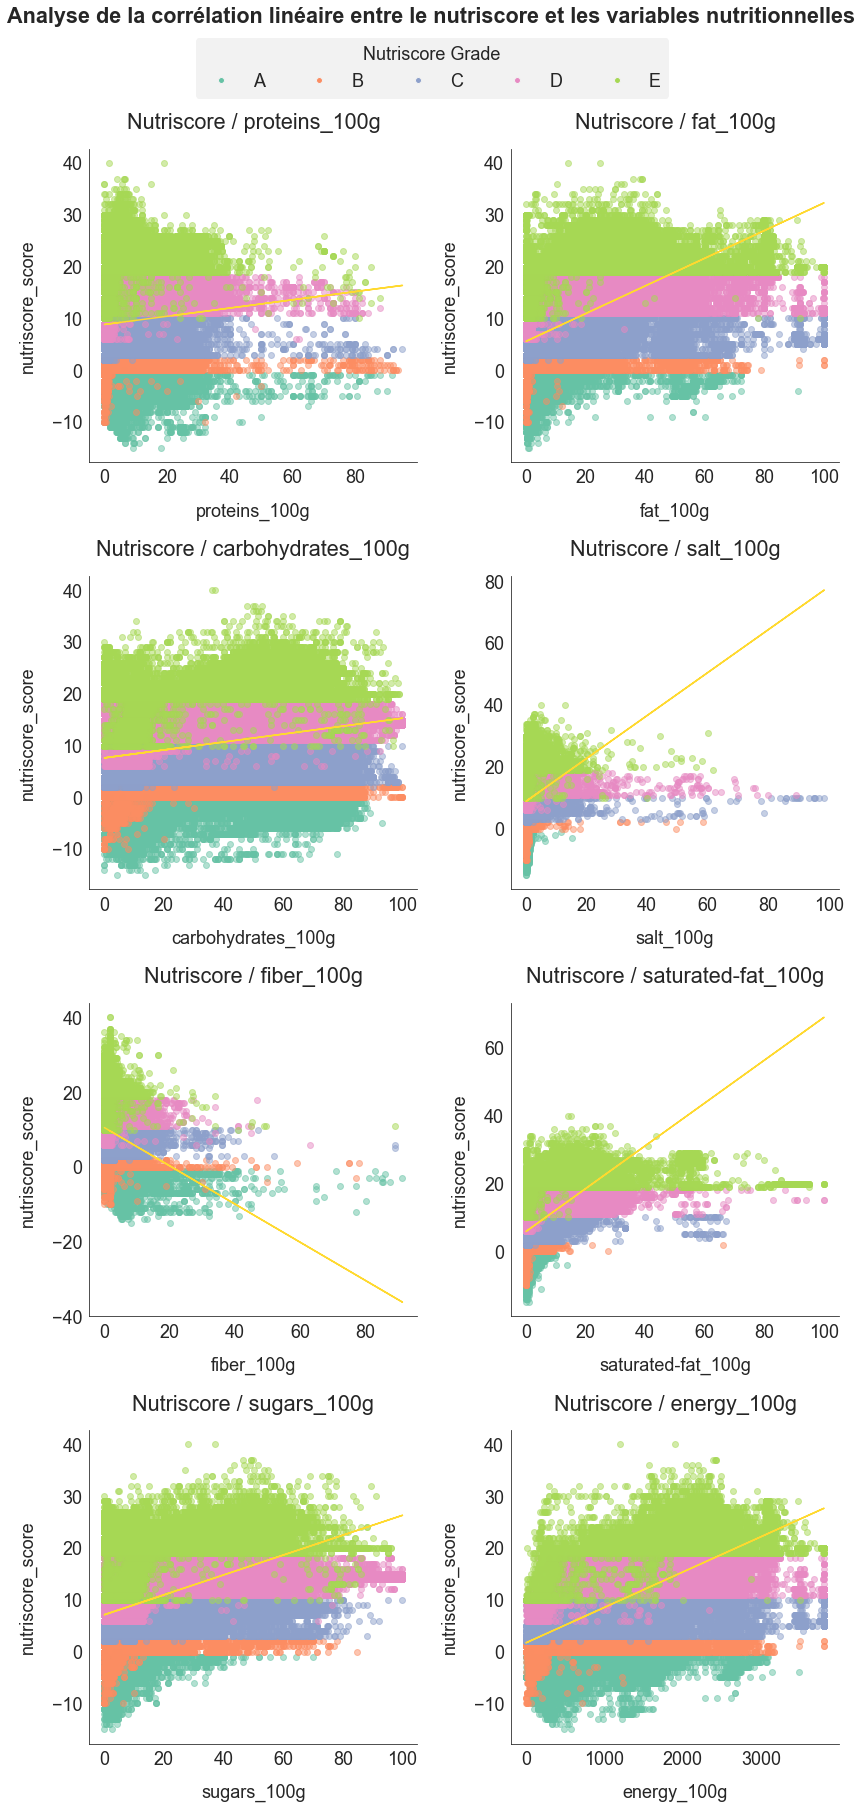

In [100]:
graph = sfg.MyGraph("Analyse de la corrélation linéaire entre le nutriscore et les variables nutritionnelles", y_title=1.05, nblin=4, nbcol=2)
for idx in range(len(col_nutri)):
    graph.graph_custom_regplot(fulldata, col_nutri[idx], "nutriscore_score", hue="nutriscore_grade", \
                           subtitle="Nutriscore / "+col_nutri[idx], legend=False, multi_index=idx+1)
fig, ax  = graph.fig, graph.ax
fig.legend(handles=my_legend_lines, ncol=5, loc='upper center', bbox_to_anchor=(0.5, 1.03), title="Nutriscore Grade")
save_fig("221_correlation_nutriscore_nutritions")
plt.show()

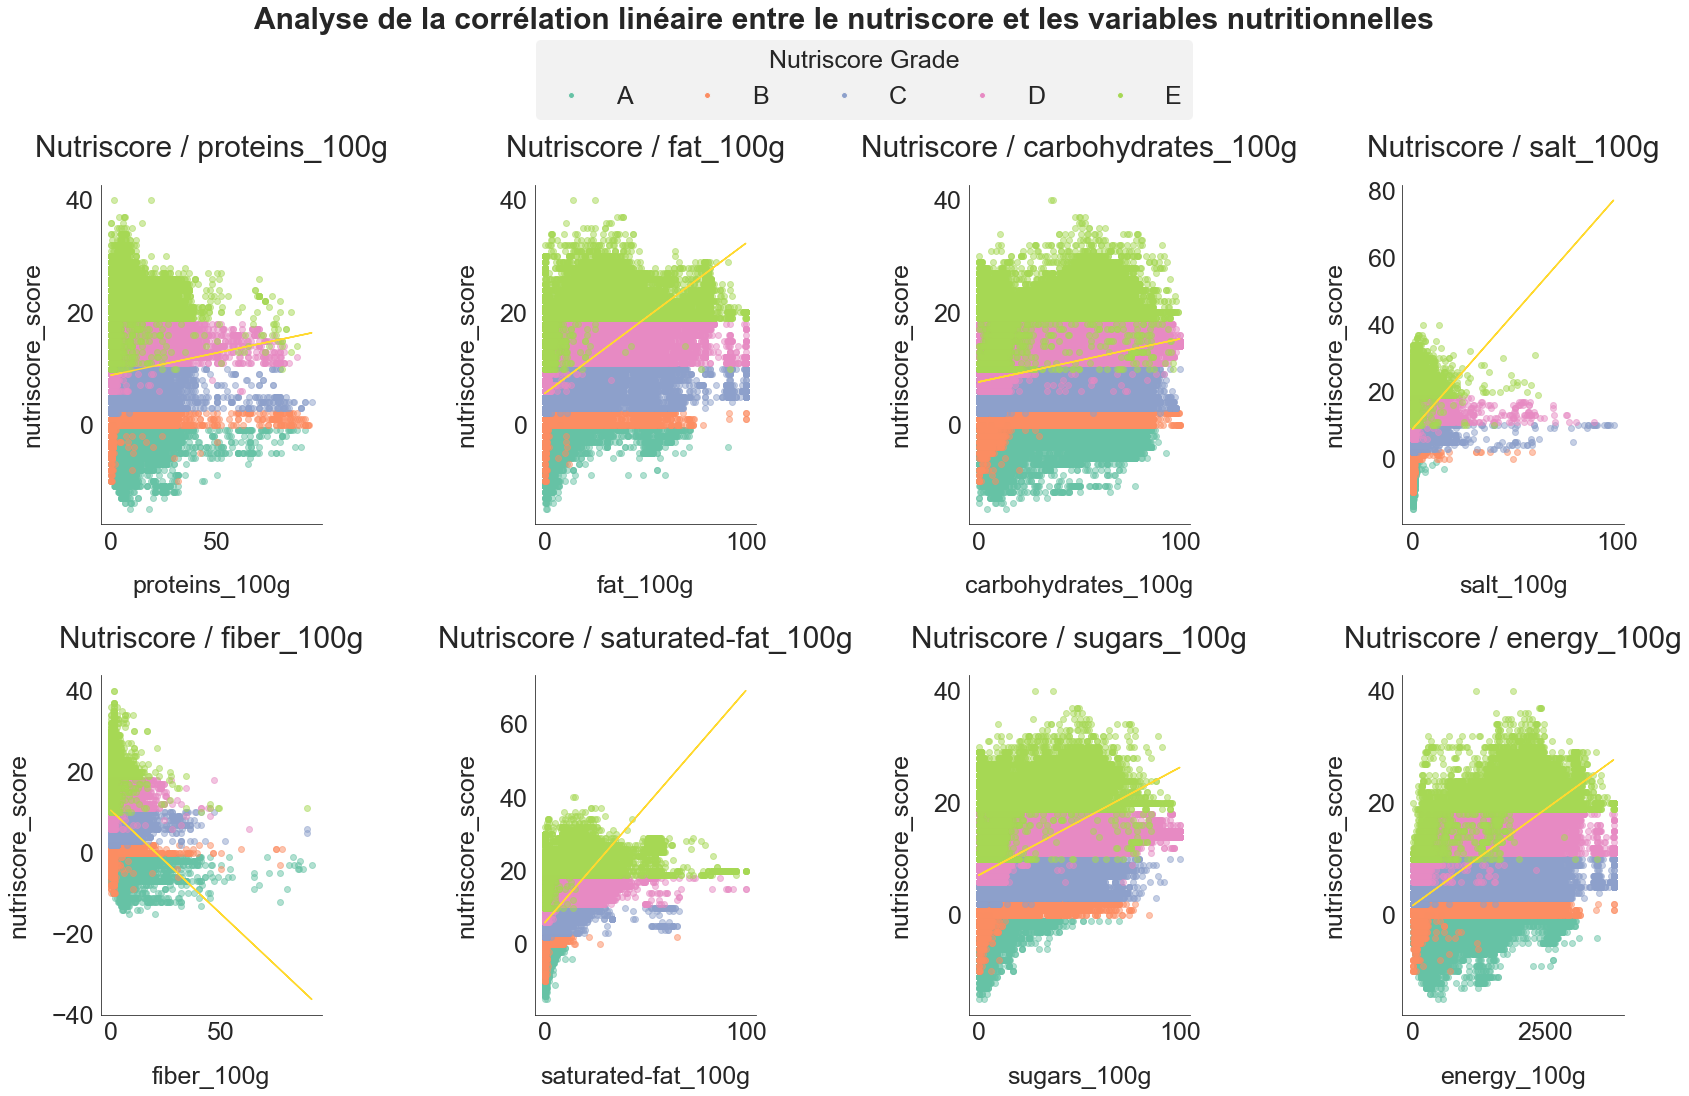

In [101]:
# autre orientation pour la présentation
graph = sfg.MyGraph("Analyse de la corrélation linéaire entre le nutriscore et les variables nutritionnelles", \
                    y_title=1.10, nblin=2, nbcol=4, wspace=0.05, figsize=(24,14))
for idx in range(len(col_nutri)):
    graph.graph_custom_regplot(fulldata, col_nutri[idx], "nutriscore_score", hue="nutriscore_grade", \
                           subtitle="Nutriscore / "+col_nutri[idx], legend=False, multi_index=idx+1)
fig, ax  = graph.fig, graph.ax
fig.legend(handles=my_legend_lines, ncol=5, loc='upper center', bbox_to_anchor=(0.5, 1.06), title="Nutriscore Grade")
save_fig("221b_correlation_nutriscore_nutritions")
plt.show()

On s'aperçoit que moins le coefficient de Pearson est élevé, moins les droites de régression linéaire semblent pertinentes, même si leur pente est forte. Cela confirme que les relations entre le nutriscore et les valeurs nutritionnelles ne sont pas linéaires.

Aucune variable nutritionnelle ne permet de différencier nettement les différentes catégories. Je note toutefois que :
- les produits avec plus de 50g de fibres sont essentiellement classés en catégorie A et B ;
- les produits avec plus de 70g de graisses saturées sont classés essentiellement en catégorie D et E ;
- les produits avec plus de 80g de sucre sont classés essentiellement en catégorie D et E.

#### 3.3.2. Relations de rang

Comme les variables n'ont pas une distribution normale, je vérifie les corrélations de rang.

In [102]:
sftd.test_correlations_rank(fulldata, "nutriscore_score", col_nutri, return_print=True)

Test de corrélation de rang (niveau de risque = 5%)
   H0: Le coefficient de corrélation de rang de la variable nutriscore_score avec les variables suivantes est nul (r=0)
   H1: Le coefficient de corrélation de rang n'est pas nul (r!=0)

                   Spearman Correlation p_value  Accept H0         Conclusion       
proteins_100g            0.115615           0      False    Coefficient significatif
fat_100g                 0.608855           0      False    Coefficient significatif
carbohydrates_100g       0.152552           0      False    Coefficient significatif
salt_100g                0.315734           0      False    Coefficient significatif
fiber_100g              -0.102802           0      False    Coefficient significatif
saturated-fat_100g       0.651806           0      False    Coefficient significatif
sugars_100g              0.283287           0      False    Coefficient significatif
energy_100g              0.622374           0      False    Coefficient significa

Les coefficients de corrélation de Spearman sont significatifs mais ont des valeurs peu élevées. Cela confirme que le nutriscore ne dépend pas d'une variable mais d'une combinaison de variables.

#### 3.3.3. Distribution des variables nutritionnelles en fonction de la catégorie nutriscore

In [103]:
catplot_data = pd.DataFrame(columns=["mesure","valeur","nutriscore_grade"])
for col in col_nutri[:3]:
    df = pd.DataFrame({"mesure": np.full(len(fulldata),col), "valeur": fulldata[col], \
                              "nutriscore_grade": fulldata["nutriscore_grade"].str.upper()})
    catplot_data = pd.concat([catplot_data, df], ignore_index=True)

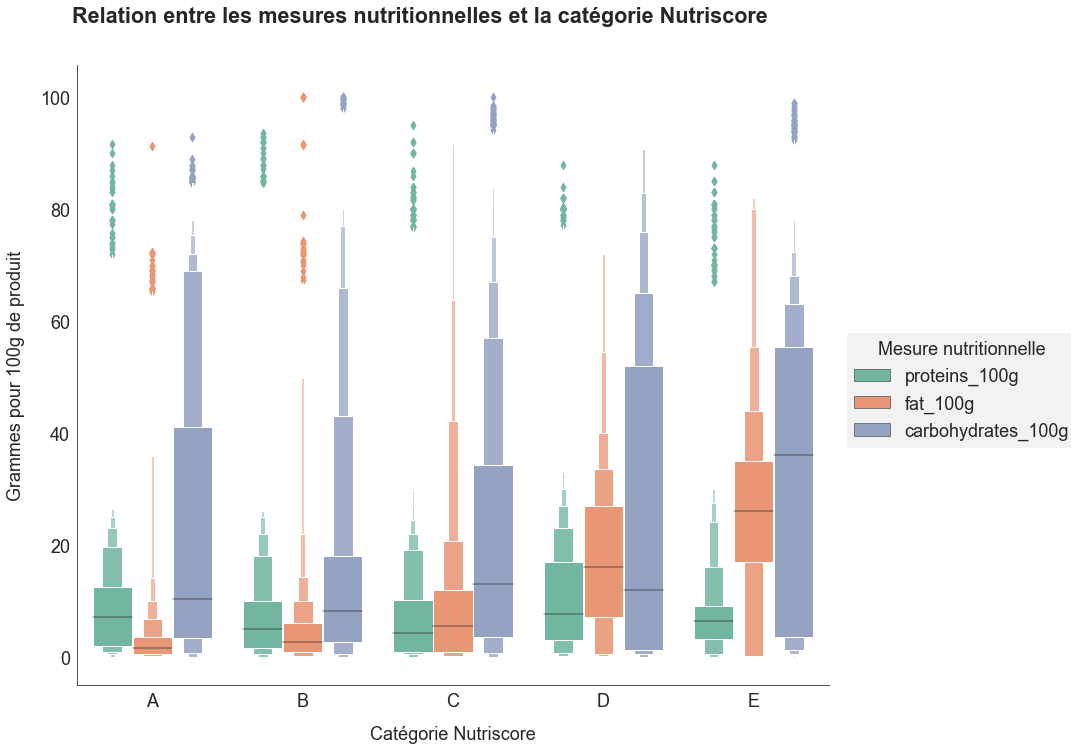

In [104]:
fig, ax = sfg.sns_catplot(x="nutriscore_grade", y="valeur", hue="mesure", data=catplot_data, \
                          kind='boxen', order=["A","B","C","D","E"], figsize=(12,10), legend=False, \
                          title="Relation entre les mesures nutritionnelles et la catégorie Nutriscore")
ax[0].set_xlabel("Catégorie Nutriscore")
ax[0].set_ylabel("Grammes pour 100g de produit")
fig.legend(loc="center left", title="Mesure nutritionnelle", bbox_to_anchor=(0.97,0.5))
save_fig("222_anova_nutriscore_nutritions1")
plt.show()

Ce graphique confirme les conclusions des corrélations linéaires :
- La catégorie de nutriscore ne semble pas dépendre de la quantité de protéines ;
- Moins il y a de graisses, plus le produit aura tendance à appartenir à une meilleure catégorie ;
- La quantité de glucides ne semble pas agir de façon décisive sur le classement du produit.

In [105]:
catplot_data = pd.DataFrame(columns=["mesure","valeur","nutriscore_grade"])
for col in col_nutri[3:-1]:
    df = pd.DataFrame({"mesure": np.full(len(fulldata),col), "valeur": fulldata[col], \
                              "nutriscore_grade": fulldata["nutriscore_grade"].str.upper()})
    catplot_data = pd.concat([catplot_data, df], ignore_index=True)

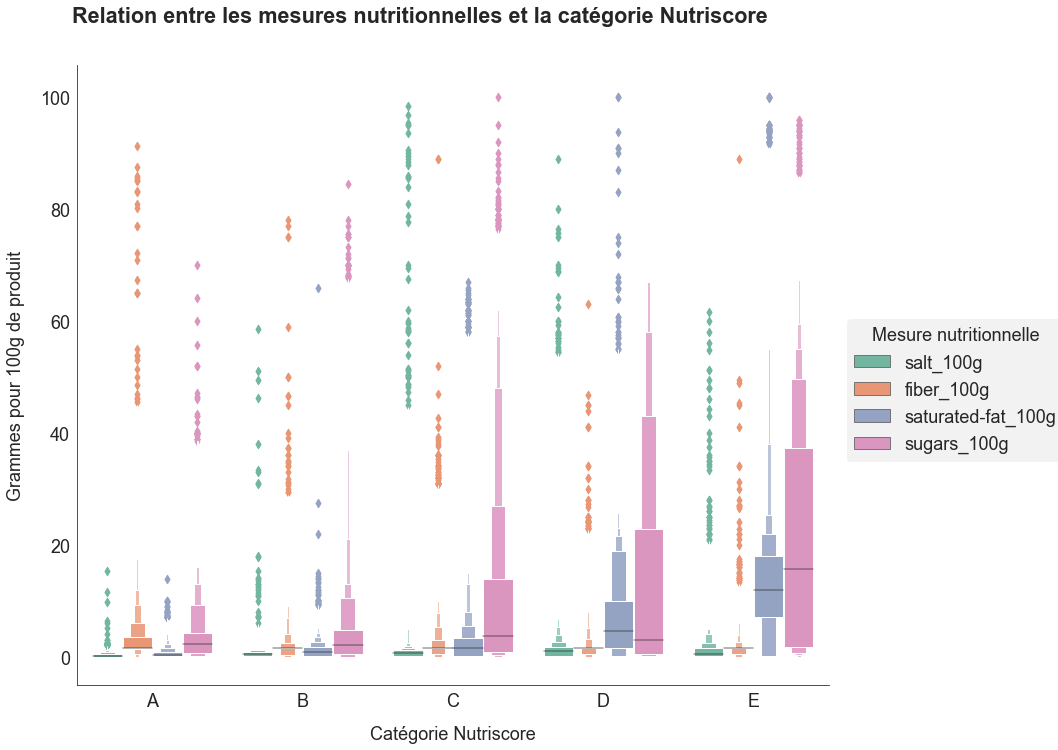

In [106]:
fig, ax = sfg.sns_catplot(x="nutriscore_grade", y="valeur", hue="mesure", data=catplot_data, \
                          kind='boxen', order=["A","B","C","D","E"], figsize=(12,10), legend=False, \
                          title="Relation entre les mesures nutritionnelles et la catégorie Nutriscore")
ax[0].set_xlabel("Catégorie Nutriscore")
ax[0].set_ylabel("Grammes pour 100g de produit")
fig.legend(loc="center left", title="Mesure nutritionnelle", bbox_to_anchor=(0.97,0.5))
save_fig("223_anova_nutriscore_nutritions2")
plt.show()

Ce graphique offre des perspectives intéressantes, qui complètent les observations précédentes :
- les produits les moins salés ont tendance à appartenir aux meilleurs catégories ;
- les produits avec le plus de fibre ont tendance à appartenir aux meilleures catégories ;
- les produits avec le moins de graisses saturées ont tendance à appartenir aux meilleures catégories (et cette tendance est plus affirmée qu'avec la quantité totale de graisses) ;
- les produits avec moins de sucre ont légèrement tendance à appartenir aux meilleures catégories.  
  
On retrouve ici les variables dont les régressions linéaires avec le nutriscore avaient les plus fortes pentes.

Je vérifie les conclusions de ces graphiques avec :
- un test de Fisher sur l'égalité des moyennes : je sais que la p-value obtenue est à prendre avec précaution car la distribution des variables testées n'est pas normale ;
- un test de Kruskal-Wallis sur l'égalité des médianes : comme ce test est non paramétrique, la non-normalité des distributions n'est pas importante.

In [107]:
sftd.test_anova_fisher(fulldata, col_nutri, "nutriscore_grade", return_print=True)

Test ANOVA de Fisher (niveau de risque = 5%)
   H0: Les moyenne des 5 groupes sont égales
   H1: Au moins une moyenne n'est pas égale aux autres

                    F Stat  p_value  Accept H0                Conclusion               
proteins_100g       1501.76     0      False    Au moins une moyenne diffère des autres
fat_100g            15187.3     0      False    Au moins une moyenne diffère des autres
carbohydrates_100g  1998.37     0      False    Au moins une moyenne diffère des autres
salt_100g           1966.91     0      False    Au moins une moyenne diffère des autres
fiber_100g          2575.85     0      False    Au moins une moyenne diffère des autres
saturated-fat_100g  23233.9     0      False    Au moins une moyenne diffère des autres
sugars_100g          7489.8     0      False    Au moins une moyenne diffère des autres
energy_100g         18900.1     0      False    Au moins une moyenne diffère des autres



In [108]:
sftd.test_anova_kruskal(fulldata, col_nutri, "nutriscore_grade", return_print=True)

C:\Anaconda3\envs\Jupyter\lib\site-packages\scipy\stats\stats.py:5879: RuntimeWarning: overflow encountered in long_scalars
  h = 12.0 / (totaln * (totaln + 1)) * ssbn - 3 * (totaln + 1)


Test ANOVA de Kruskal-Wallis (non-paramétrique) (niveau de risque = 5%)
   H0: Les médianes des 5 groupes sont égales
   H1: Au moins une médiane n'est pas égale aux autres

                      H Stat    p_value  Accept H0                Conclusion               
proteins_100g       2.55194e+07     0      False    Au moins une médiane diffère des autres
fat_100g             2.7551e+07     0      False    Au moins une médiane diffère des autres
carbohydrates_100g  2.54933e+07     0      False    Au moins une médiane diffère des autres
salt_100g           2.61927e+07     0      False    Au moins une médiane diffère des autres
fiber_100g          3.37584e+07     0      False    Au moins une médiane diffère des autres
saturated-fat_100g  2.79937e+07     0      False    Au moins une médiane diffère des autres
sugars_100g         2.61006e+07     0      False    Au moins une médiane diffère des autres
energy_100g         2.76728e+07     0      False    Au moins une médiane diffère des autre

Les tests ANOVA concluent qu'au moins une catégorie a une moyenne et une médiane différente des autres catégories, quelque soit la valeur nutritionnelle étudiée. Cela confirme l'analyse visuelle des graphiques.  
Nous concluons de cette analyse visuelle que **<font color=red>notre modèle d'estimation du nutriscore a intérêt à se baser sur les variables salt_100g, fiber_100g, saturated-fat_100g et sugars_100g.</font>**

#### 3.3.4. Distribution de l'énergie en fonction de la catégorie nutriscore

In [109]:
catplot_data = pd.DataFrame({"mesure": np.full(len(fulldata),"Energy_100g"), "valeur": fulldata["energy_100g"], \
                   "nutriscore_grade": fulldata["nutriscore_grade"].str.upper()})

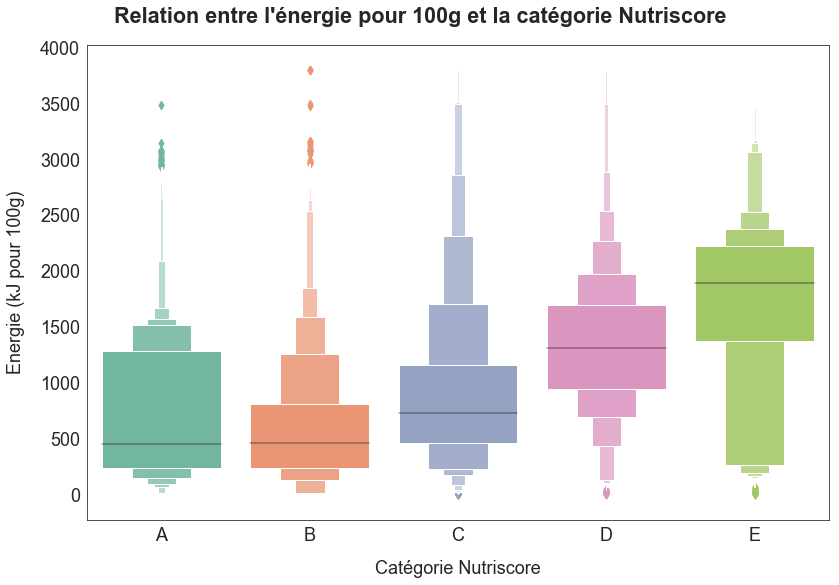

In [110]:
graph = sfg.MyGraph("Relation entre l'énergie pour 100g et la catégorie Nutriscore")
graph.add_sns_boxenplot(x="nutriscore_grade", y="valeur", data=catplot_data, \
                        order=["A","B","C","D","E"])
graph.set_axe_x(label="Catégorie Nutriscore")
graph.set_axe_y(label="Energie (kJ pour 100g)")
fig, ax= graph.fig, graph.ax
save_fig("224_anova_nutriscore_energy")
plt.show()

Les produits les plus énergétiques ont tendance à appartenir à une moins bonne catégorie (D et E). La différence entre les produits de catégorie A, B et C est moins évidente.

**<font color=red>Notre modèle d'estimation du nutriscore aura donc intérêt à se baser sur la variable energy_100g.</font>**

<a id='3_4'></a>

### 3.4. Etude du lien entre le label bio et le nutriscore

#### 3.4.1. Lien entre le label bio et la catégorie nutriscore

In [111]:
label_grade = sfco.Contingency(fulldata, "is_bio", "nutriscore_grade")

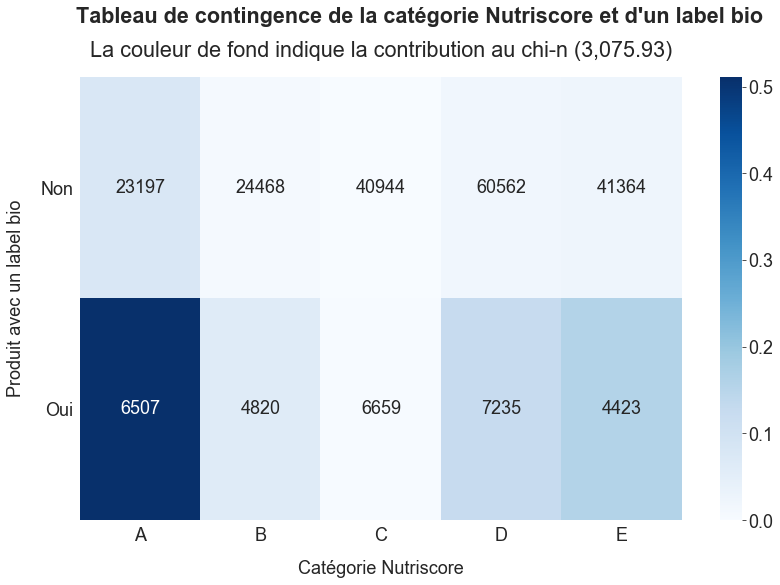

In [112]:
fig, ax = label_grade.graph_contingency(x_label="Catégorie Nutriscore",
                              y_label="Produit avec un label bio",
                              title="Tableau de contingence de la catégorie Nutriscore et d'un label bio",
                              x_tick_labels=label_grade.contingency_table.columns.str.upper(),
                              y_tick_labels=["Non","Oui"])
save_fig("225_contingence_nutriscore_isbio")
plt.show()

In [113]:
label_grade.print_contingency_table()

In [114]:
label_grade.print_expected_table()

In [115]:
label_grade.print_contributions_table()

Test du Chi² pour étudier si la catégorie de Nutriscore est indépendante du label bio.

In [116]:
label_grade.test_chi2(return_print=True)

Test de l'hypothèse d'indépendance des fréquences observées dans le tableau de contingence (niveau de risque = 5%)
   H0: Les variables is_bio et nutriscore_grade sont indépendantes
   H1: Les variables is_bio et nutriscore_grade ne sont pas indépendantes
Statistique étudiée : chi2 à 4 degrés de liberté = 3075.933
p-value = 0.000
Accept H0 : False



In [117]:
label_grade.print_etude_dependance()

Le test du Chi² conclut que les variables is_bio et nutriscore_grade sont dépendantes, au niveau de risque de 5%.  
L'observation des résidus ajustés montre que les produits avec un label bio sont sur-représentés dans les catégories A et B et sous-représentés dans les labels D et E.

#### 3.4.2. Lien entre le nutriscore et l'appartenance à un label bio

In [118]:
catplot_data = fulldata[["nutriscore_score","is_bio"]].copy()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


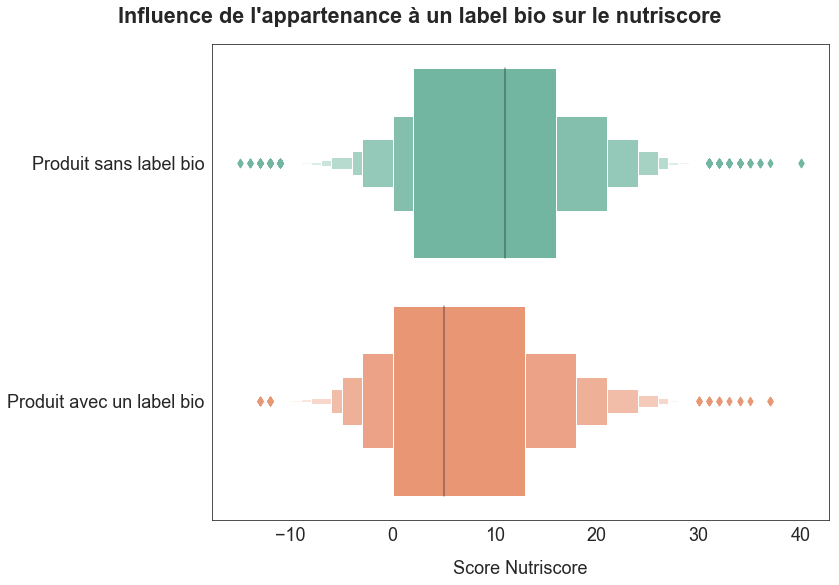

In [191]:
graph = sfg.MyGraph("Influence de l'appartenance à un label bio sur le nutriscore")
graph.add_sns_boxenplot(x="nutriscore_score", y="is_bio", orient='h', data=catplot_data)
graph.set_axe_x(label="Score Nutriscore")
graph.set_axe_y(label="", tick_labels=["Produit sans label bio","Produit avec un label bio"])
fig, ax= graph.fig, graph.ax
save_fig("226_anova_nutriscore_isbio")
plt.show()

In [120]:
sftd.test_anova_fisher(fulldata, ["nutriscore_score"], "is_bio", return_print=True)

Test ANOVA de Fisher (niveau de risque = 5%)
   H0: Les moyenne des 2 groupes sont égales
   H1: Au moins une moyenne n'est pas égale aux autres

                  F Stat  p_value  Accept H0                Conclusion               
nutriscore_score  3109.27     0      False    Au moins une moyenne diffère des autres



In [121]:
sftd.test_anova_kruskal(fulldata, ["nutriscore_score"], "is_bio", return_print=True)

Test ANOVA de Kruskal-Wallis (non-paramétrique) (niveau de risque = 5%)
   H0: Les médianes des 2 groupes sont égales
   H1: Au moins une médiane n'est pas égale aux autres

                    H Stat   p_value  Accept H0                Conclusion               
nutriscore_score  2.5437e+07     0      False    Au moins une médiane diffère des autres



C:\Anaconda3\envs\Jupyter\lib\site-packages\scipy\stats\stats.py:5879: RuntimeWarning: overflow encountered in long_scalars
  h = 12.0 / (totaln * (totaln + 1)) * ssbn - 3 * (totaln + 1)


Il n'y a que deux catégories. Je peux remplacer le test de Fisher par un t-test, et le test de Kruskal par le test de Mann-Whitney.

In [122]:
sftd.test_egalite_moyennes(fulldata[fulldata.is_bio].nutriscore_score, fulldata[~fulldata.is_bio].nutriscore_score, \
                           equal_var=True, return_print=True)

T-test de Student d'égalité des moyennes de deux échantillons (niveau de risque = 5%)
   H0: Les moyennes des 2 échantillons sont égales
   H1: Les moyennes des 2 échantillons sont différentes
Statistique étudiée : t de Student à 220177 degrés de liberté = -55.761
p-value = 0.000
Accept H0 : False



In [123]:
sftd.test_egalite_medianes(fulldata[fulldata.is_bio].nutriscore_score, fulldata[~fulldata.is_bio].nutriscore_score, \
                           alternative='less', return_print=True)

Test U de Mann-Whitney d'égalité des médianes de deux échantillons (non paramétrique) (niveau de risque = 5%)
   H0: Les médianes des 2 échantillons sont égales
   H1: La médiane du premier groupe est inférieure à la médiane du deuxième groupe
Statistique étudiée : loi normale (asymptotiquement) = 2255172099.500
p-value = 0.000
Accept H0 : False



**Les produits avec un label bio tendent à avoir de meilleurs scores que les produits sans label bio**, ce qui vient confirmer notre étude sur la dépendance de la catégorie de nutriscore et de label bio.

**<font color=red>Notre modèle d'estimation du nutriscore aura donc intérêt à se baser sur la variable is_bio.</font>**

---
<a id='4_0'></a>

## <font color=blue>4. Réduction dimensionnelle

J'effectue une réduction dimensionnelle pour étudier la corrélation entre les variables numériques.  
J'utilise donc toutes les variables sauf le nutriscore_grade.

L'ACP utilise un module qui encapsule les fonctions d'ACP de sklearn. Pour commencer, les données sont centrées et réduites à l'aide d'un StandarScaler.

In [124]:
acp = sfrd.ACP(fulldata)

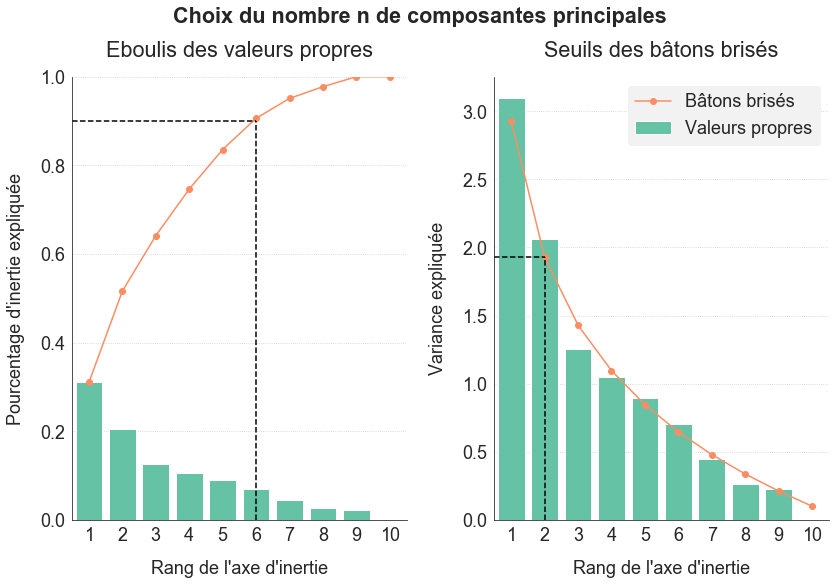

In [125]:
fig, ax = acp.graphique_choix_n(seuil_inertie=0.9)
save_fig("227_acp_choix_n")
plt.show()

Le graphique des bâtons brisés est intéressant. Les valeurs propres de chaque axe d'inertie sont très proches d'une distribution aléatoire de l'inertie entre les différents axes d'inertie, qui est représentée par les bâtons brisés.  
Le graphique des éboulis des valeurs propres montre qu'il faut aller juqu'à 6 composantes principales pour expliquer 90% de la l'inertie.

Ces deux graphiques montrent la même chose : **la relation entre les variables n'est pas linéaire**. En conséquence, l'ACP a du mal à concentrer l'inertie dans les premiers axes d'inertie.

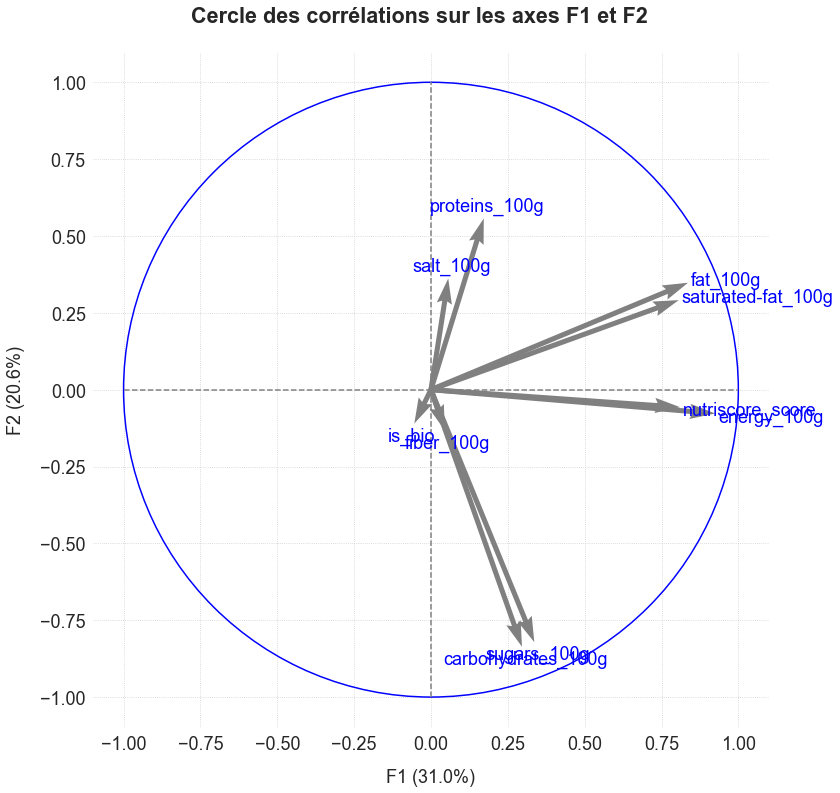

In [126]:
fig, ax = acp.graphique_correlation_circles(y_title=0.95)
save_fig("228_correlation_circle_f1f2")
plt.show()

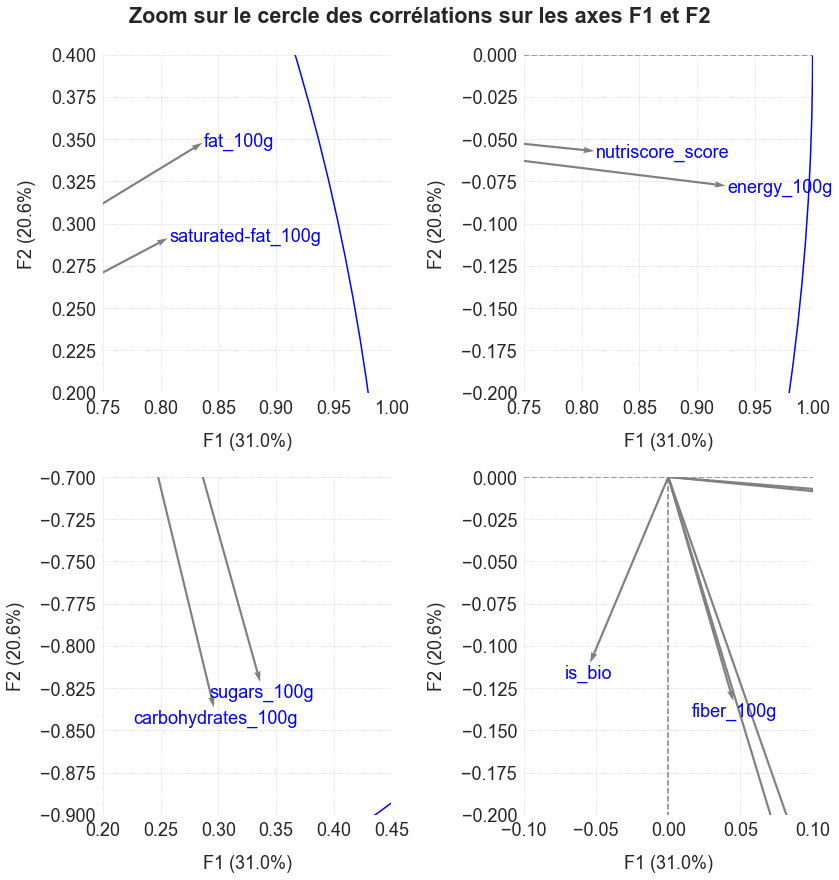

In [127]:
fig, ax = acp.zoom_correlation_circle(zooms=[[0.75,1,0.2,0.4],[0.75,1,-0.20,0],[0.2,0.45,-0.9,-0.7],[-0.1,0.1,-0.2,0]], y_title=1.025)
save_fig("229_zoom_correlation_circle_f1f2")
plt.show()

Interprétation des axes d'inertie:
- Le premier axe d'inertie représente le caractère énergétique et gras d'un aliment. Plus cet aliment est sur la droite de cet axe, plus son nutriscore sera mauvais (pour rappel, plus haut est le nutriscore, moins la note du produit est bonne).
- Le deuxième axe d'inertie met en balance les protéines avec les glucides et sucres contenus dans le produit. Plus l'aliment est vers le haut de l'axe, plus il est protéiné et moins il contient de glucides et sucres.
- Les variables salt_100g, is_bio et fiber_100g sont très mal représentés par ces 2 axes d'inertie.

Ce graphique confirme nos analyses bivariées précédentes : les paires de variables nutrition_score et energy_100g, fat_100g et saturated-fat_100g, carbohydrates_100g et sugars_100g sont très liées.  
Toutefois il est difficile d'obtenir une estimation fiable de leurs corrélations car elles ne sont pas suffisamment bien représentées sur ces axes d'inertie (qualité de représentation <= 0.70 pour toutes les variables sauf energy_100g).

In [128]:
acp.print_etude_variables(n_components=4)

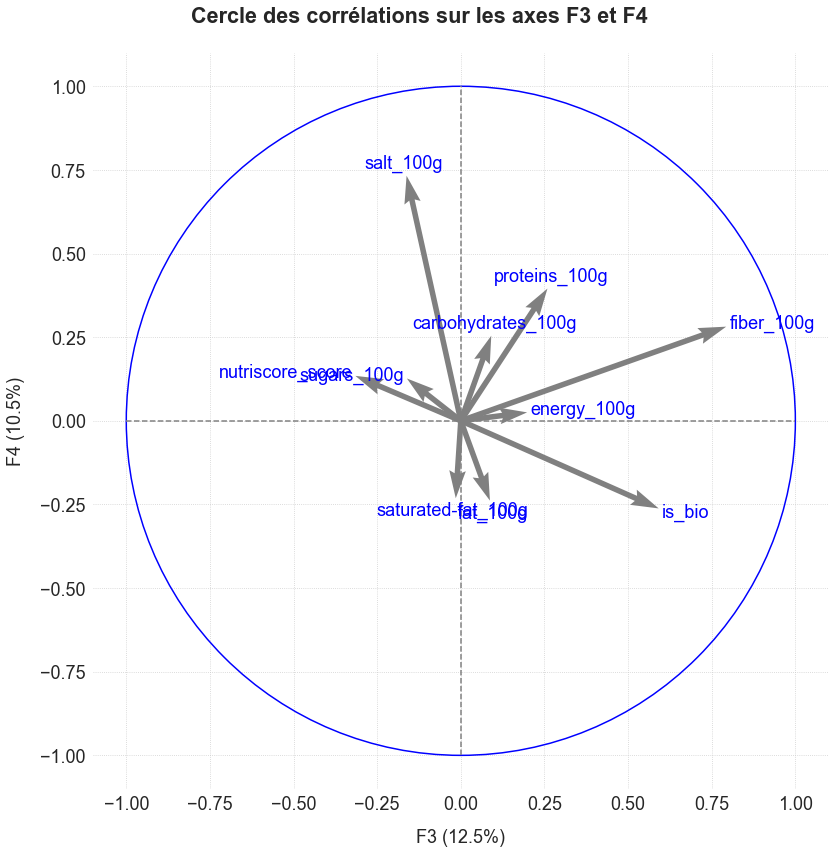

In [129]:
fig, ax = acp.graphique_correlation_circles(axis_ranks=[3,4])
save_fig("230_correlation_circle_f3f4")
plt.show()

Les troisième et quatrième axes d'inertie sont principalement représentatifs des variables moins bien représentés par les 2 premiers axes :
- Le troisième axe d'inertie représente le caractère sain de l'aliment : un aliment est sur la droite de l'axe s'il a un fort apport nutritionnel en fibres et s'il a un label bio ;
- Le quatrième axe d'inertie représente le caractère salé de l'aliment : plus un aliment est salé, plus il se situe vers le haut de l'axe.

Les qualités de représentation sur ces deux axes ne sont pas suffisamment bonnes pour en déduire des corrélations entre variables.

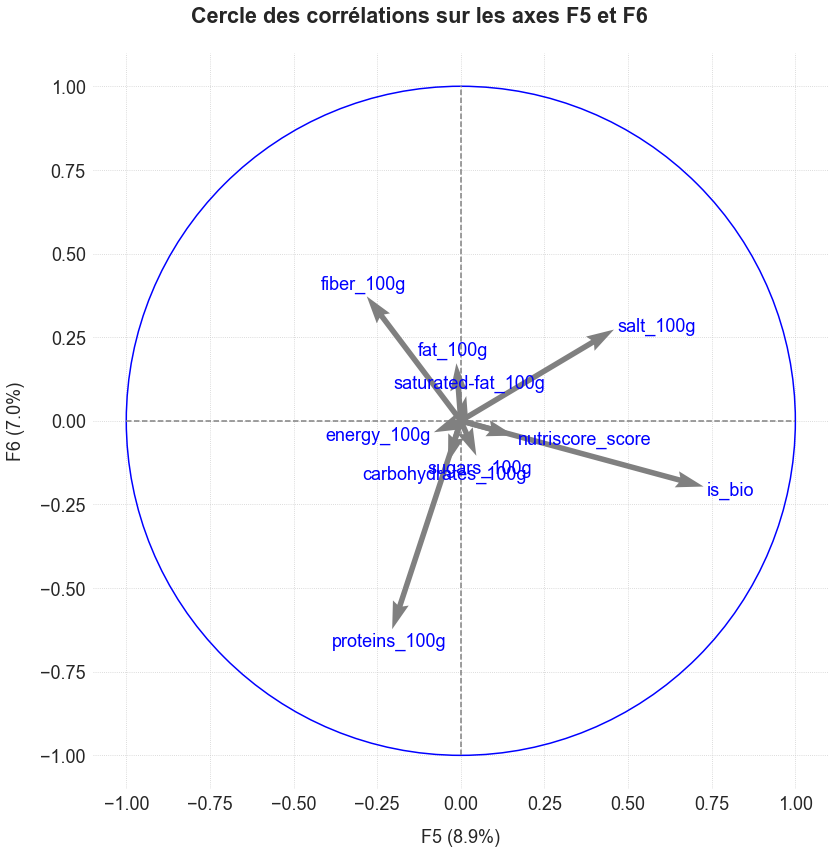

In [130]:
fig, ax = acp.graphique_correlation_circles(axis_ranks=[5,6])
save_fig("231_correlation_circle_f5f6")
plt.show()

Les axes d'inertie de rang 5 et 6 sont difficilement interprétables sous un angle nouveau. Je choisis de ne pas les utiliser.

**<font color=red>Le modèle d'estimation du nutriscore peut gagner à se baser sur les quatre premiers axes d'inertie</font>**, à la place ou en plus d'autres variables.

In [131]:
data_plot = acp.data_projected.copy()
data_plot["Category"] = fulldata["nutriscore_grade"].str.upper()
data_plot.head()

F1 (31.0%)  F2 (20.6%)  F3 (12.5%)  F4 (10.5%)  F5 (8.9%)  \
code                                                                       
0000000000100    0.031743   -0.242757   -1.518673    1.298368   1.018613   
0000000000949   -2.144615    0.111115   -0.494171   -0.526893  -0.236747   
0000000001281    1.247917   -0.401310    0.290385   -0.301380  -0.592992   
0000000001885   -1.505735   -1.474215    0.216300   -0.027550  -0.658674   
0000000002257   -1.471762    0.423327   -0.278641   -0.739842  -0.359507   

               F6 (7.0%)  F7 (4.5%)  F8 (2.6%)  F9 (2.3%)    F10 (0.0%)  \
code                                                                      
0000000000100   0.325325   0.078754  -0.238050  -0.138290 -5.166617e-15   
0000000000949   0.634946   0.168909   0.033289   0.058955 -9.283268e-15   
0000000001281   0.794342   0.817371   0.315752   0.132389  7.566218e-15   
0000000001885   0.604531  -0.002469   0.149401   0.680765 -1.136323e-14   
0000000002257   0.687317  -0.291719  -0.187900   0.136343  1.430384e-15   

              Category  
code                    
0000000000100        D  
0000000000949        B  
0000000001281        D  
0000000001885        A  
0000000002257        B

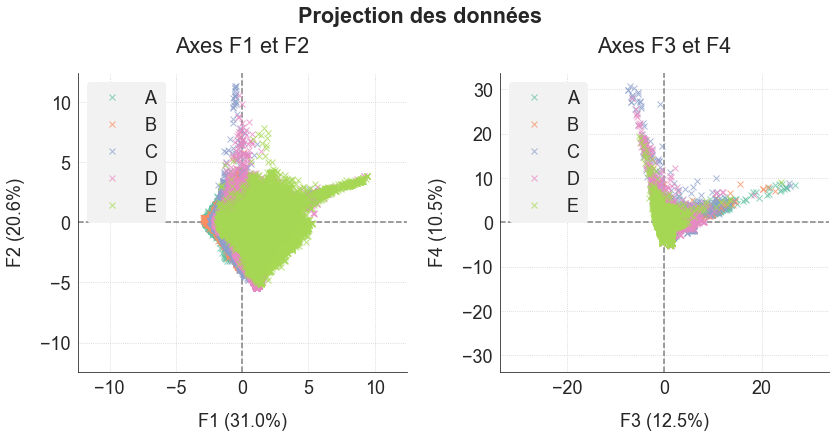

In [132]:
fig, ax = acp.graphique_data_projected(data_plot, axis_ranks=[[1,2],[3,4]], hue="Category", hue_color_base_index=0)
save_fig("232_factorial_planes_1234")
plt.show()

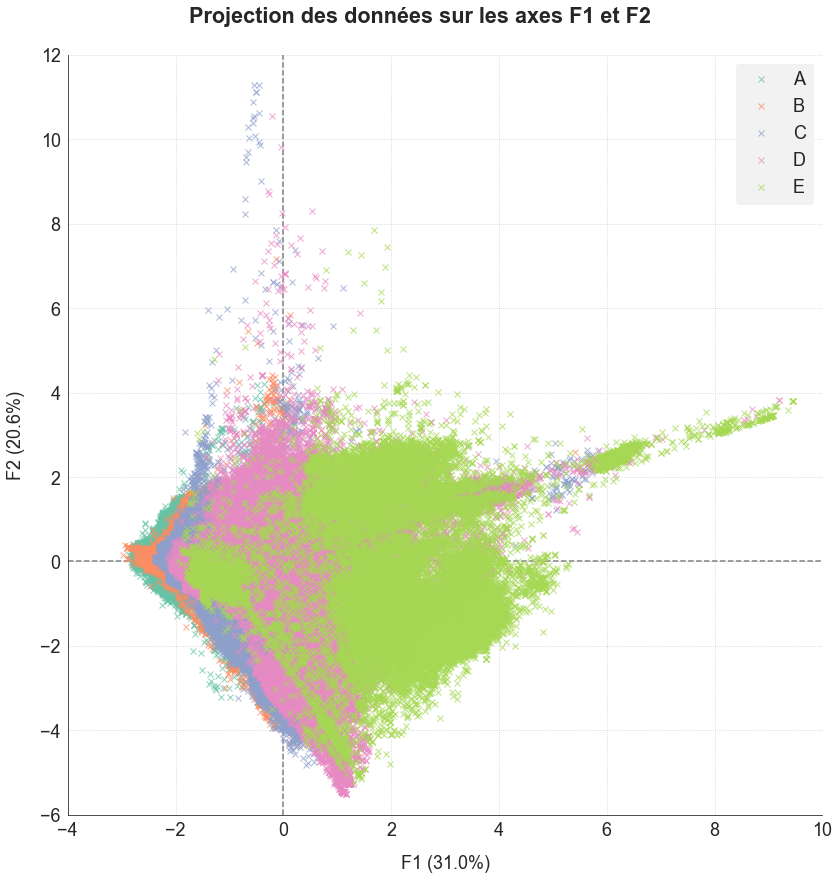

In [133]:
fig, ax = acp.graphique_data_projected(data_plot, axis_ranks=[1,2], hue="Category", hue_color_base_index=0, limits=[-4,10,-6,12])
save_fig("233_factorial_planes_f1f2")
plt.show()

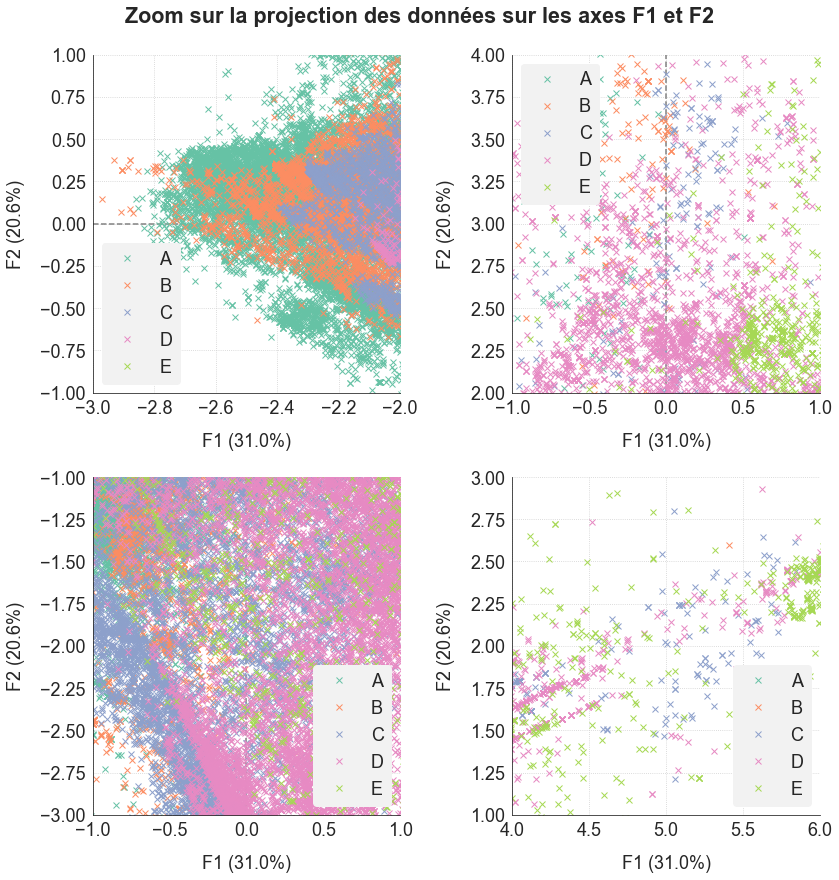

In [134]:
fig, ax = acp.zoom_data_projected(data_plot, zooms=[[-3,-2,-1,1],[-1,1,2,4],[-1,1,-3,-1],[4,6,1,3]], marker_alpha=1, hue="Category", hue_color_base_index=0)
save_fig("234_zoom_factorial_planes_f1f2")
plt.show()

Les produits avec les meilleures catégories de nutriscore ont tendance à être regroupés sur la gauche du premier axe d'inertie. En faisant des zooms, on s'aperçoit que les produits des différentes catégories ne sont pas très bien différenciés par le premier plan factoriel.

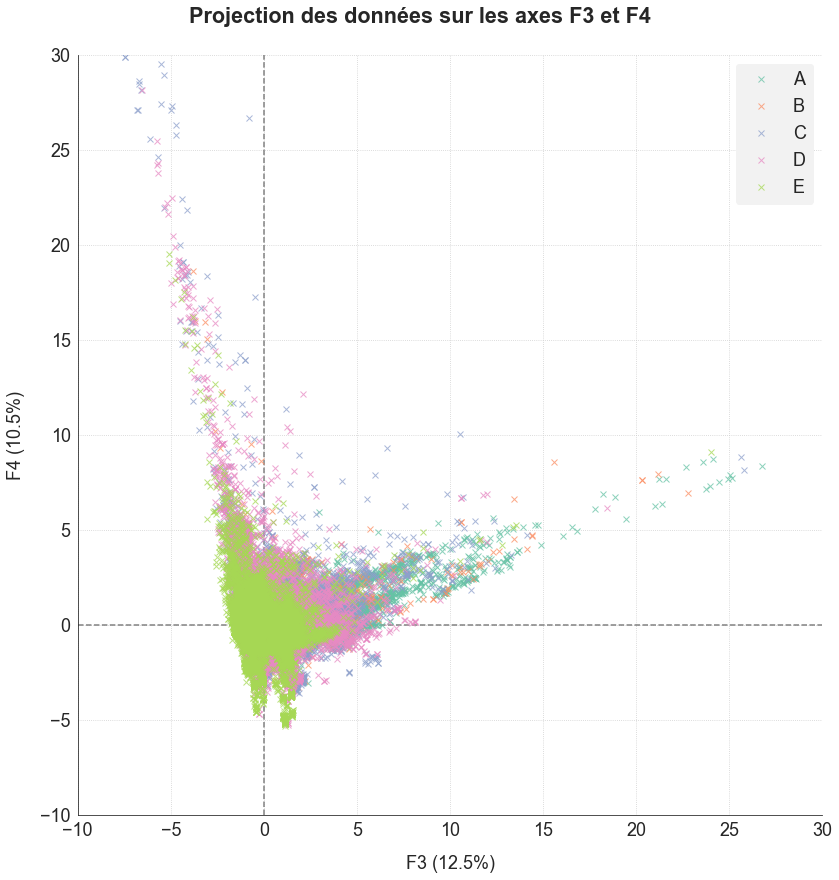

In [135]:
fig, ax = acp.graphique_data_projected(data_plot, axis_ranks=[3,4], hue="Category", hue_color_base_index=0, limits=[-10,30,-10,30])
save_fig("235_factorial_planes_f3f4")
plt.show()

Le deuxième plan factoriel apporte des informations intéressantes avec les produits les mieux notés regroupés sur la droite du troisième axe d'inertie.

---
<a id='5_0'></a>

## <font color=blue>5. Modèle knn pour remplir les nutriscores manquants</font>

Je teste 3 approches sur les données : toutes les colonnes numériques, les colonnes numériques retenues lors de mon analyse des données et les 4 premiers axes principaux de l'acp.

Note sur les variables numériques retenues :
- proteins_100g ne semblait pas avoir d'influence sur la catégorie de nutriscore : elle n'est pas retenue ;
- fat_100g et saturated-fat_100g sont très liées : seule saturated_fat_100g est retenue car elle semble plus impactante sur le nutriscore ;
- carbohydrates_100g et sugars_100g sont très liées : seule sugars_100g a une influence nette sur la catégorie de nutriscore. Elle est donc retenue et j'abandonne carbohydrates_100g.

A ce stade, l'objectif n'est pas de tester tous les modèles possibles mais de se faire une idée de la faisabilité du projet.

### 5.1. Recalcul d'une ACP sans le nutriscore

Je dois recalculer une ACP si je veux utiliser les projections de l'ACP comme données de mon modèle. En effet, il ne faut pas que le nutriscore soit inclus dans l'ACP car c'est la variable que je cherche à estimer.

In [136]:
acp_model = sfrd.ACP(fulldata.drop(columns=["nutriscore_score","nutriscore_grade"]))

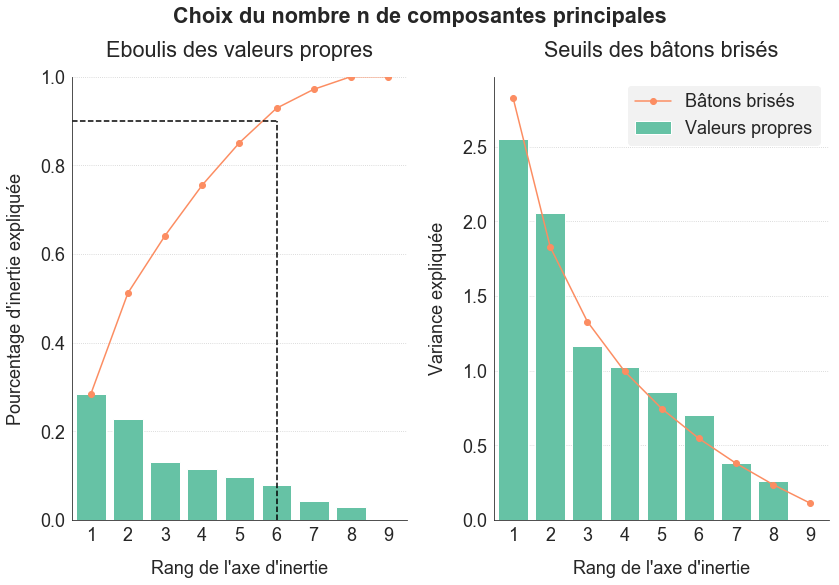

In [137]:
fig, ax = acp_model.graphique_choix_n(seuil_inertie=0.9)
plt.show()

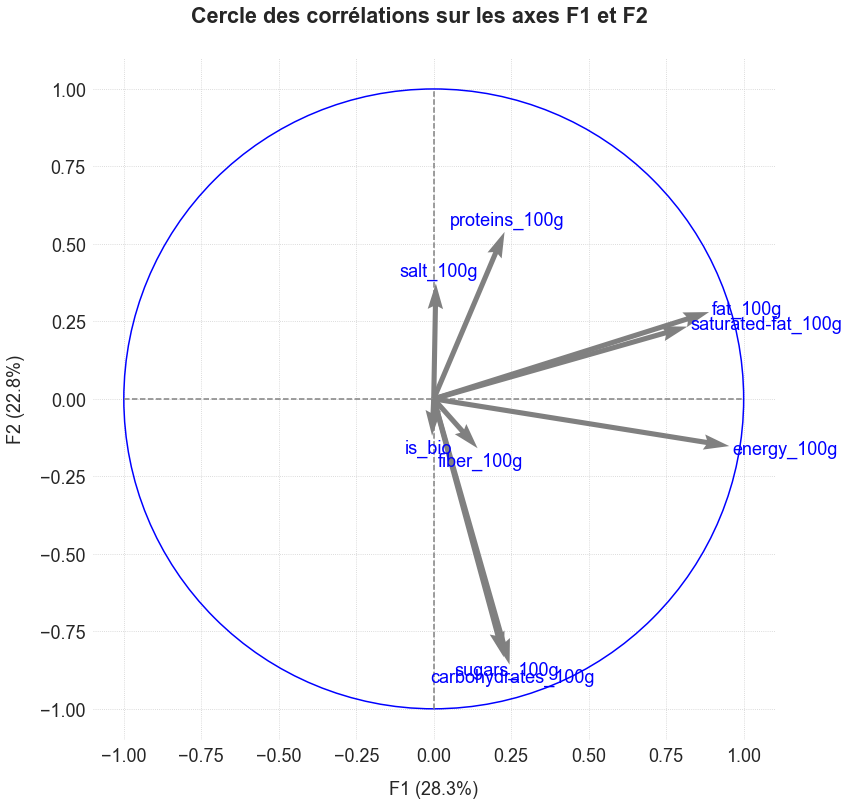

In [138]:
fig, ax = acp_model.graphique_correlation_circles(y_title=0.98)
plt.show()

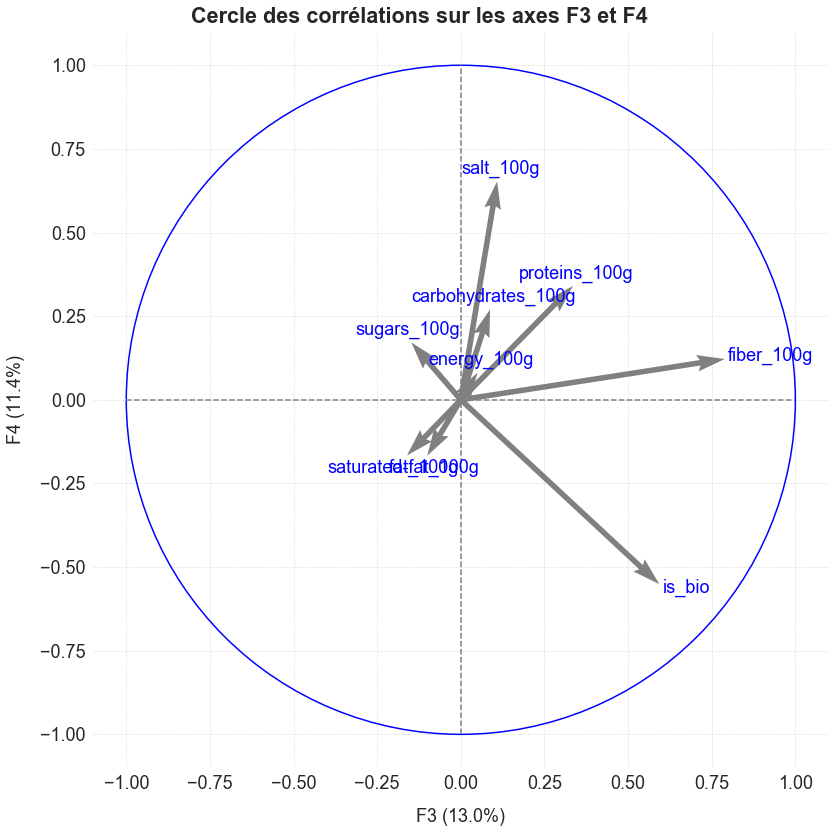

In [139]:
fig, ax = acp_model.graphique_correlation_circles(axis_ranks=[3,4], y_title=0.98)
plt.show()

L'ACP sans le nutriscore est très similaire à celle que nous avons étudié précédemment.

<a id='5_2'></a>

### 5.2. Préparation des données pour la modélisation

In [140]:
columns_select = ["salt_100g","fiber_100g","saturated-fat_100g","sugars_100g","energy_100g","is_bio"]
data_tout = fulldata.drop(columns=["product_name","image_url"])
data_select = data_tout[columns_select].copy()
data_acp = acp_model.data_projected.iloc[:,:4].copy()

**Détermination des train et test dataset**

In [141]:
train_tout, test_tout, train_select, test_select, train_acp, test_acp = \
    train_test_split(data_tout, data_select, data_acp, \
                     test_size=0.2, stratify=fulldata.nutriscore_grade, random_state=42)
train_labels = train_tout[["nutriscore_grade","nutriscore_score"]].copy()
train_tout = train_tout.drop(columns=["nutriscore_grade","nutriscore_score"])
test_labels = test_tout[["nutriscore_grade","nutriscore_score"]].copy()
test_tout = test_tout.drop(columns=["nutriscore_grade","nutriscore_score"])

**Normalisation des données**

In [142]:
scaler_tout = StandardScaler().fit(train_tout.values)
scaler_select = StandardScaler().fit(train_select.values)
scaler_acp = StandardScaler().fit(train_acp.values)

In [143]:
train_tout_scaled = scaler_tout.transform(train_tout.values)
train_select_scaled = scaler_select.transform(train_select.values)
train_acp_scaled = scaler_acp.transform(train_acp.values)

In [144]:
test_tout_scaled = scaler_tout.transform(test_tout.values)
test_select_scaled = scaler_select.transform(test_select.values)
test_acp_scaled = scaler_acp.transform(test_acp.values)

<a id='5_3'></a>

### 5.3. Test de modèles de classification

Je commence par tester un modèle de classification qui estime la catégorie nutriscore des produits. Un modèle de classification permet une mesure intuitive des résultats avec le taux de précision et la matrice de confusion.

Je fais un premier essai avec un KNN classifieur. Comme je n'ai pas de relation linéaire, un modèle knn devrait mieux foncitonner qu'une régression logistique. Je vérifie ce point en testant également une régression logistique et des dummy classifiers.

In [145]:
def print_scores(scores, nom_score, modele, donnees):
    print("{} - {} - {}".format(modele, donnees, nom_score))
    print("Scores: ", scores)
    print("Mean: {:.2%}".format(scores.mean()))
    print("Standard deviation: {:.2%}".format(scores.std()))
    print()

In [146]:
def test_classifieur(input_model, input_data, data_labels, modele, donnees):
    input_model.fit(input_data, labels)
    scores = cross_val_score(input_model, input_data, labels, scoring="accuracy", cv=5)
    print_scores(scores, "Accuracy", modele, donnees)

#### 5.3.1 Essai avec un classifieur kNN

Le but est de prédire la catégorie du nutriscore.

In [147]:
labels = train_labels.nutriscore_grade.values

In [148]:
knn = KNeighborsClassifier()
modele = "Modèle knn"

**Premier essai sur toutes les données**

In [149]:
input_data = train_tout_scaled.copy()
donnees = "Toutes données numériques"
test_classifieur(knn, input_data, labels, modele, donnees)
print("Nombre de variables : {}".format(input_data.shape[1]))

Modèle knn - Toutes données numériques - Accuracy
Scores:  [0.83246757 0.83209856 0.83346107 0.83257636 0.83189508]
Mean: 83.25%
Standard deviation: 0.05%

Nombre de variables : 9


**Sur les colonnes sélectionnées**

In [150]:
input_data = train_select_scaled.copy()
donnees = "Colonnes numériques sélectionnées"
test_classifieur(knn, input_data, labels, modele, donnees)
print("Nombre de variables : {}".format(input_data.shape[1]))

Modèle knn - Colonnes numériques sélectionnées - Accuracy
Scores:  [0.82329899 0.81881405 0.82173777 0.82579198 0.82110821]
Mean: 82.22%
Standard deviation: 0.23%

Nombre de variables : 6


**Sur les 4 premiers axes d'inertie**

In [151]:
input_data = train_acp_scaled.copy()
donnees = "4 premiers axes d'inertie"
test_classifieur(knn, input_data, labels, modele, donnees)
print("Nombre de variables : {}".format(input_data.shape[1]))

Modèle knn - 4 premiers axes d'inertie - Accuracy
Scores:  [0.7859434  0.78171393 0.78651111 0.78326899 0.78136709]
Mean: 78.38%
Standard deviation: 0.21%

Nombre de variables : 4


**Premières observations**

La sélection des colonnes paraît pertinente. Le taux de pertinence passe de 83,30% avec l'ensemble des 9 colonnes à 82.23% avec la sélection de 6 colonnes. La diminution de la dimension n'entraîne pas une baisse notable du taux de pertinence. Et elle permet d'obtenir une grande stabilité des résultats avec un faible écart-type.

La faible capacité de concentration de l'inertie de l'ACP fait que les résultats obtenus en prenant les quatre premiers axes d'inertie sont moins bons et peu intéressants.

#### 5.3.2. Essai avec une régression logistique

Je ne fais le test que sur la sélection de colonne pour deux raisons :
- j'ai supprimé les colonnes fortement corrélées ce qui devrait éviter les problèmes de colinéarité ;
- je ne cherche qu'à confirmer l'intuition que les résultats ne seront pas bons car les variables ne sont liées linéairement.

In [152]:
logreg = LogisticRegression()
modele = "Régression logistique"

**Sur les colonnes sélectionnées**

In [153]:
input_data = train_select_scaled.copy()
donnees = "Colonnes numériques sélectionnées"
test_classifieur(logreg, input_data, labels, modele, donnees)

Régression logistique - Colonnes numériques sélectionnées - Accuracy
Scores:  [0.56666383 0.5724829  0.56981464 0.57406041 0.57201658]
Mean: 57.10%
Standard deviation: 0.26%



Comme attendu, la régression logistique donne des résultats bien moins bons que l'approche knn.

#### 5.3.3. Comparaison avec des dummy classifiers

In [154]:
input_data = train_select_scaled.copy()
test_data = test_select_scaled.copy()
test_target = test_labels.nutriscore_grade.values

**Dummy classifier 'most frequent'**

Prédit toujours la classe la plus représentée dans les données d'entraînement.

In [155]:
strategy = "most_frequent"
dummy_clf = DummyClassifier(strategy=strategy)
dummy_clf.fit(input_data, labels)
print("Taux de précision sur les données d'entraînement du dummy classifier '{}' = {:.2%}".\
      format(strategy, dummy_clf.score(input_data, labels)))
print("Taux de précision sur les données de test du dummy classifier '{}' = {:.2%}".\
      format(strategy, dummy_clf.score(test_data, test_target)))

Taux de précision sur les données d'entraînement du dummy classifier 'most_frequent' = 30.79%
Taux de précision sur les données de test du dummy classifier 'most_frequent' = 30.79%


**Dummy classifier 'stratified'**

Prédit aléatoirement en respectant la proportion de catégorie dans les données d'entraînement.

In [156]:
strategy = "stratified"
dummy_clf = DummyClassifier(strategy=strategy, random_state=42)
dummy_clf.fit(input_data, labels)
print("Taux de précision sur les données d'entraînement du dummy classifier '{}' = {:.2%}".\
      format(strategy, dummy_clf.score(input_data, labels)))
print("Taux de précision sur les données de test du dummy classifier '{}' = {:.2%}".\
      format(strategy, dummy_clf.score(test_data, test_target)))

Taux de précision sur les données d'entraînement du dummy classifier 'stratified' = 22.18%
Taux de précision sur les données de test du dummy classifier 'stratified' = 22.17%


**Dummy classifier 'uniform'**

Prédit les classes aléatoirement selon une distribution uniforme.

In [157]:
strategy = "uniform"
dummy_clf = DummyClassifier(strategy=strategy, random_state=42)
dummy_clf.fit(input_data, labels)
print("Taux de précision sur les données d'entraînement du dummy classifier '{}' = {:.2%}".\
      format(strategy, dummy_clf.score(input_data, labels)))
print("Taux de précision sur les données de test du dummy classifier '{}' = {:.2%}".\
      format(strategy, dummy_clf.score(test_data, test_target)))

Taux de précision sur les données d'entraînement du dummy classifier 'uniform' = 19.90%
Taux de précision sur les données de test du dummy classifier 'uniform' = 20.15%


**Conclusion**

On obtient un taux de précision sur les données d'entraînement bien meilleur avec notre modèle. Je vérifierai les taux de précision sur les données de test lorsque j'évaluerai la généralisation du modèle retenu.

<a id='5_4'></a>

### 5.4. Optimisation des hyper-paramètres du modèle knn

In [158]:
knn_clf = KNeighborsClassifier()
grade_labels = train_labels.nutriscore_grade.values
grade_modele = "Modèle knn"
input_data = train_select_scaled.copy()
donnees = "Colonnes numériques sélectionnées"

Je fais une approche simple de grid search en cherchant le meilleur nombre de voisins et la meilleure fonction de poids.

In [159]:
param_grid = [{'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
               'weights': ['uniform','distance']}]
grid_search_clf = GridSearchCV(knn_clf, param_grid, cv=5, scoring='accuracy')

In [160]:
grid_search_clf.fit(input_data, grade_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [161]:
grid_search_clf.best_params_

{'n_neighbors': 11, 'weights': 'distance'}

In [162]:
grid_search_clf.best_score_

0.8378249627782897

Le meilleur modèle est obtenu avec 11 voisins et une pondération des poids en fonction de la distance. Il atteint un taux de précision de 83.78%.

<a id='5_5'></a>

### 5.5. Evaluation de la généralisation avec les données de test

**Taux de précision sur les données de test**

Je vérifie que l'accuracy reste similaire sur les données que le modèle n'a pas encore vu.

In [163]:
test_data = test_select_scaled.copy()
grade_test_target = test_labels.nutriscore_grade.values
grade_estimation = grid_search_clf.predict(test_data)
accuracy_score(grade_test_target, grade_estimation)

0.8424016713597965

La généralisation obtient une précision de 83.84%, similaire à la précision obtenue sur les données d'entraînement. Elle confirme la qualité du modèle.

**Matrice de confusion des catégories estimées**

In [164]:
confusion_matrix(grade_test_target, grade_estimation)

array([[ 5017,   625,   189,    38,    72],
       [  737,  4214,   733,   103,    71],
       [  238,   696,  7584,   762,   241],
       [   53,    97,   736, 12208,   465],
       [  112,    95,   303,   574,  8073]], dtype=int64)

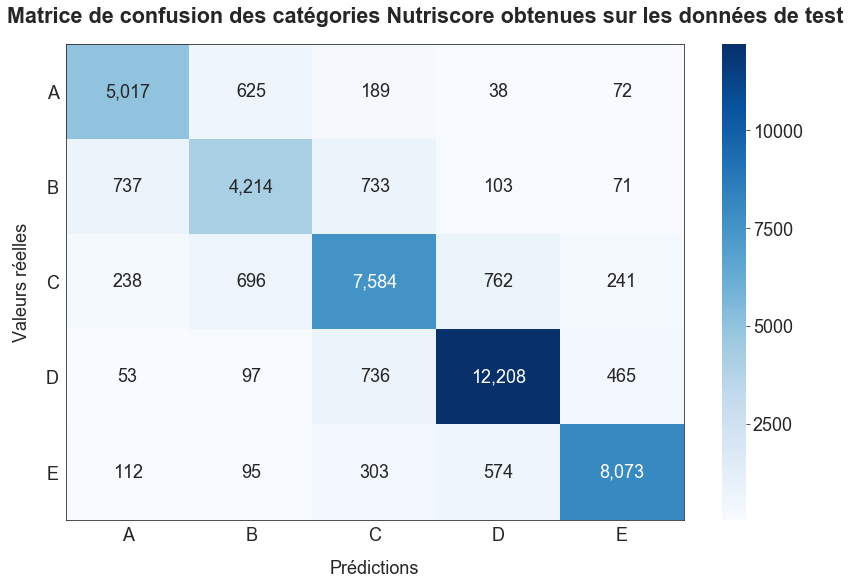

In [186]:
graph = sfg.MyGraph("Matrice de confusion des catégories Nutriscore obtenues sur les données de test", figsize=(12,8))
graph.graph_confusion_matrix(grade_test_target, grade_estimation, values_format=',.0f', labels_capitalize=True)
fig, ax = graph.fig, graph.ax
save_fig("236_knn_clf_confusion_matrix")
plt.show()

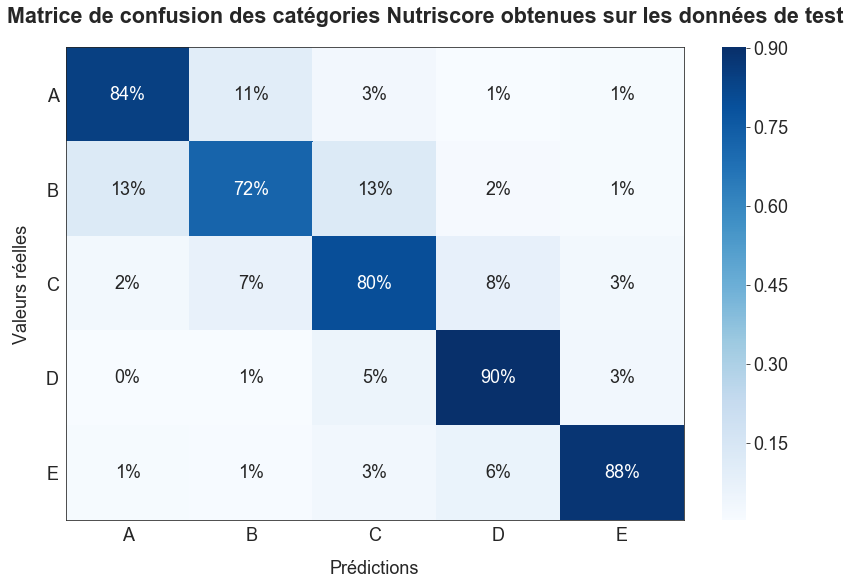

In [188]:
graph = sfg.MyGraph("Matrice de confusion des catégories Nutriscore obtenues sur les données de test", figsize=(12,8))
graph.graph_confusion_matrix(grade_test_target, grade_estimation, normalize='true', values_format='.0%', labels_capitalize=True)
fig, ax = graph.fig, graph.ax
save_fig("236b_knn_clf_confusion_matrix")
plt.show()

Les prédictions restent assez imprécises.  
Les prédictions de la catégorie B traduisent cette imprécision. Un produit solide est en catégorie B si son score est compris entre 0 et 2 (inclus). Sur ce petit intervalle, on voit que la précision n'est que de 72%.  
Les bons pourcentages des autres catégories viennent en partie de la largeur de l'intervalle des notes éligibles à la catégorie : les catégories A, D et E sont les catégories avec les plus grands écarts de score.

<a id='5_6'></a>

### 5.6. Estimation des catégories nutriscore_grade manquantes

In [168]:
idx_to_fill = data[data.nutriscore_grade.isna()].index
input_data = data[data.nutriscore_grade.isna()][columns_select].values
input_data_scaled = scaler_select.transform(input_data)
estimation_grades = grid_search_clf.predict(input_data_scaled)
data.loc[idx_to_fill,"nutriscore_grade"] = estimation_grades

<a id='5_7'></a>

### 5.7. Extension du raisonnement aux scores nutriscore_score manquants

**Recherche des meilleurs hyper-paramètres pour le régresseur kNN**

In [169]:
knn_reg = KNeighborsRegressor()
score_labels = train_labels.nutriscore_score.values
score_modele = "Régresseur knn"
input_data = train_select_scaled.copy()
donnees = "Colonnes numériques sélectionnées"

In [170]:
param_grid = [{'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
               'weights': ['uniform','distance']}]
grid_search_reg = GridSearchCV(knn_reg, param_grid, cv=5, scoring='neg_root_mean_squared_error')

In [171]:
grid_search_reg.fit(input_data, score_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [172]:
grid_search_reg.best_params_

{'n_neighbors': 15, 'weights': 'distance'}

Je trouve un nombre voisin qui est à la limite de ma grille de recherche. Je fais une nouvelle recherche en étendant les valeurs testées.

In [173]:
param_grid = [{'n_neighbors': [15, 17, 19, 21, 23],
               'weights': ['uniform','distance']}]
grid_search_reg = GridSearchCV(knn_reg, param_grid, cv=5, scoring='neg_root_mean_squared_error')

In [174]:
grid_search_reg.fit(input_data, score_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [15, 17, 19, 21, 23],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [175]:
grid_search_reg.best_params_

{'n_neighbors': 17, 'weights': 'distance'}

In [176]:
grid_search_reg.best_score_

-2.475884582547803

Le meilleur modèle est obtenu avec 17 voisins et une pondération des poids en fonction de la distance. Il atteint un RMSE de 2,476.

**Evaluation de la généralisation du modèle**

In [177]:
test_data = test_select_scaled.copy()
score_test_target = test_labels.nutriscore_score.values
score_estimation = grid_search_reg.predict(test_data)
mean_squared_error(score_test_target, score_estimation, squared=False)

2.443375536317539

La généralisation donne un score légèrment meilleur à celui obtenu sur les données d'entraînement. Je compare à un Dummy Regressor pour valider la qualité du modèle.

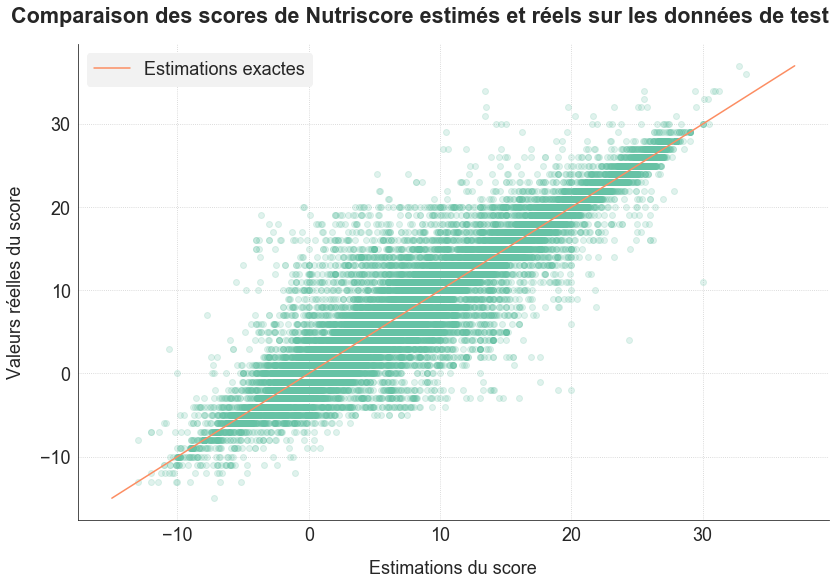

In [178]:
min_plot = score_test_target.min()
max_plot = score_test_target.max()
graph = sfg.MyGraph("Comparaison des scores de Nutriscore estimés et réels sur les données de test")
graph.add_plot(score_estimation, score_test_target, label="", marker='o', alpha=0.2, linestyle='')
graph.add_plot([min_plot,max_plot],[min_plot,max_plot], label="Estimations exactes", with_grid='both', grid_style=':', legend=True)
graph.set_axe_x(label="Estimations du score")
graph.set_axe_y(label="Valeurs réelles du score")
fig, ax  = graph.fig, graph.ax
save_fig("237_knn_reg_estimates_target")
plt.show()

Les valeurs les plus basses et les plus élevées du nutriscore sont celles qui sont le mieux estimées : la dispersion des valeurs estimées est moindre pour ces valeurs.  
L'estimation du score est trop imprécise pour une application professionnelle.

In [179]:
correl_data = pd.DataFrame({'target': score_test_target, 'estimation': score_estimation, 'grade': grade_test_target})
sftd.test_correlations_linear(correl_data, "target", ["estimation"], return_print=True)

Test de corrélation linéaire (niveau de risque = 5%)
   H0: Le coefficient de corrélation linéaire de la variable target avec les variables suivantes est nul (r=0)
   H1: Le coefficient de corrélation linéaire n'est pas nul (r!=0)

           Pearson Correlation p_value  Accept H0         Conclusion       
estimation       0.960715          0      False    Coefficient significatif



In [190]:
sftd.test_correlations_rank(correl_data, "target", ["estimation"], return_print=True)

Test de corrélation de rang (niveau de risque = 5%)
   H0: Le coefficient de corrélation de rang de la variable target avec les variables suivantes est nul (r=0)
   H1: Le coefficient de corrélation de rang n'est pas nul (r!=0)

           Spearman Correlation p_value  Accept H0         Conclusion       
estimation       0.958433           0      False    Coefficient significatif



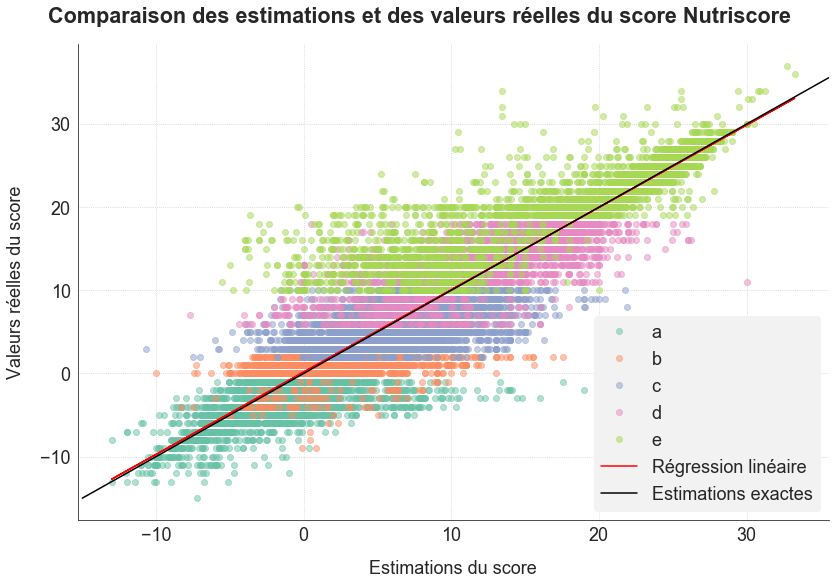

In [180]:
graph = sfg.MyGraph("Comparaison des estimations et des valeurs réelles du score Nutriscore")
graph.graph_custom_regplot(correl_data, "estimation", "target", hue="grade", reg_color='red')
graph.add_plot([min_plot,max_plot],[min_plot,max_plot], label="Estimations exactes", color='black', with_grid='both', grid_style=':', legend=True)
graph.set_axe_x(label="Estimations du score")
graph.set_axe_y(label="Valeurs réelles du score")
fig, ax  = graph.fig, graph.ax
save_fig("238_knn_reg_estimates_target_correl")
plt.show()

La régression linéaire des valeurs réelles du nutriscore en fonction des estimations du nutriscore se confond quasi-parfaitement avec la ligne des estimations exactes.

**Evaluation du modèle face à un dummy regressor**

Dummy regressor basé sur la moyenne

In [181]:
strategy = "mean"
dummy_reg = DummyRegressor(strategy=strategy)
dummy_reg.fit(input_data, score_labels)
estimation = dummy_reg.predict(input_data)
print("RMSE sur les données d'entraînement du dummy regressor '{}' = {:.3f}".\
      format(strategy, mean_squared_error(score_labels, estimation, squared=False)))
estimation = dummy_reg.predict(test_data)
print("RMSE sur les données de test du dummy regressor '{}' = {:.3f}".\
      format(strategy, mean_squared_error(score_test_target, estimation, squared=False)))

RMSE sur les données d'entraînement du dummy regressor 'mean' = 8.790
RMSE sur les données de test du dummy regressor 'mean' = 8.794


Dummy regressor basé sur la médiane

In [182]:
strategy = "median"
dummy_reg = DummyRegressor(strategy=strategy)
dummy_reg.fit(input_data, score_labels)
estimation = dummy_reg.predict(input_data)
print("RMSE sur les données d'entraînement du dummy regressor '{}' = {:.3f}".\
      format(strategy, mean_squared_error(score_labels, estimation, squared=False)))
estimation = dummy_reg.predict(test_data)
print("RMSE sur les données de test du dummy regressor '{}' = {:.3f}".\
      format(strategy, mean_squared_error(score_test_target, estimation, squared=False)))

RMSE sur les données d'entraînement du dummy regressor 'median' = 8.804
RMSE sur les données de test du dummy regressor 'median' = 8.807


**Conclusion**

Notre modèle est largement meilleur que le dummy regressor : la RMSE est plus de 3.5 inférieure avec notre modèle.  
Toutefois, nos estimations restent trop imprécises pour obtenir une note fiable.

**Estimation des scores nutriscore manquants**

In [183]:
idx_to_fill = data[data.nutriscore_score.isna()].index
input_data = data[data.nutriscore_score.isna()][columns_select].values
input_data_scaled = scaler_select.transform(input_data)
estimation_scores = grid_search_reg.predict(input_data_scaled)
data.loc[idx_to_fill,"nutriscore_score"] = estimation_scores

In [184]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 516330 entries, 0000000000017 to 99999995
Data columns (total 13 columns):
product_name          515053 non-null object
image_url             466890 non-null object
proteins_100g         516330 non-null float64
fat_100g              516330 non-null float64
carbohydrates_100g    516330 non-null float64
salt_100g             516330 non-null float64
fiber_100g            516330 non-null float64
saturated-fat_100g    516330 non-null float64
sugars_100g           516330 non-null float64
energy_100g           516330 non-null float64
nutriscore_score      516330 non-null float64
nutriscore_grade      516330 non-null object
is_bio                516330 non-null bool
dtypes: bool(1), float64(9), object(3)
memory usage: 71.7+ MB


Toutes les données manquantes de nutriscore sont maintenant remplies.

---
<a id='6_0'></a>

## <font color=blue>6. Conclusions</font>

Pour commencer, je sauvegarde mon dataframe avec les données manquantes du nutriscore complétées.

In [185]:
data.to_csv("openfoodfacts_final_data.csv")

Notre idée originale d'application ne peut pas être réalisée car les données concernant le nombre d'ingrédients issus de l'huile de palme et le nombre d'additifs ne sont pas fiables. Donc le caractère sain et écologique ne peut pas être estimé de la façon envisagée.  

L'estimation du nutriscore n'est pas assez précise pour fournir au consommateur une note fiable.

Le principal problème vient de la qualité des données. Les données semblent comporter beaucoup d'erreurs. Nous avons détecté les plus évidentes lors de notre nettoyage. Mais les données étant saisies manuellement par des volontaires, elles peuvent comporter de nombreuses autres erreurs difficilement détectables, ce qui rend difficile une exploitation de ces données.

Développer une telle application signifie créer sa propre base de données sur les valeurs nutritionnelles et la composition des aliments, pour avoir des données aux valeurs correctes.